<a href="https://colab.research.google.com/github/mfrdixon/alpha-RNN/blob/master/Copy_of_Alpha_RNNs_regime_switching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import sys
sys.path.append('/content/drive/My Drive')

In [0]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import pandas as pd
from numpy import random
import os# Generate switching data set
import random


# Imports for alpha_rnns 
from IPython import display
import tensorflow.compat.v1 as tf   
tf.disable_v2_behavior()
# Imports for stats

import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit
from keras import optimizers
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU, SimpleRNN
from keras import optimizers
from keras.callbacks import EarlyStopping
from keras.regularizers import l1,l2
from keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
#from alphaRNN import *

# To make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

Instructions for updating:
non-resource variables are not supported in the long term


Using TensorFlow backend.


In [0]:
def generate_vol_sample(length, sigma_0, n_steps, step_size, eps=0.01):
    sigma = np.array([0]*length, dtype='float64')
    sigma[0]=sigma_0
    mu = np.array([0]*length, dtype='float64')
    step_length=np.int(np.floor(np.float(length)/(2.0*n_steps)))
    
    for i in range(2*n_steps):
      mu[i*step_length:((i*step_length)+1)]=step_size*(-1)**i
     
    for i in range(1, length):
        sigma[i]=sigma[i-1] + mu[i] + eps*np.random.normal(0,1)
        
    return sigma   


In [0]:
def generate_vol_sample(length, sigma_0, n_steps, step_size, p, eps=0.01, shift=0):
    sigma = np.array([0]*length, dtype='float64')
    sigma[0]=sigma_0
    mu = np.array([0]*length, dtype='float64')
    phi = np.array([0]*length*p, dtype='float64').reshape(length,p)
    #phi2 = np.array([0]*length, dtype='float64')
    step_length=100 #np.int(np.floor(np.float(length)/(2.0*n_steps)))
    
    for i in range(2*n_steps):
      #mu[i*step_length:((i*step_length)+1)]=step_size #*(-1)**i
      mu[i*step_length:((i+1)*step_length)]= step_size*(-1)**i
      if i%2==0:  
        phi[i*step_length:((i+1)*step_length),:]= 0.02
        #phi2[i*step_length:((i+1)*step_length)]=1.0
      else:
        phi[i*step_length:((i+1)*step_length),:]=0.01
        #phi2[i*step_length:((i+1)*step_length)]=0.5
    for i in range(p, length):
        sigma[i]= mu[i-1] + np.random.normal(0,eps)
        for j in range(p):
          sigma[i]+=phi[i-1,j]*sigma[i-j]  
        
    return (sigma+shift)

In [0]:
p = 30 # the number of lags (in both the data and the models)
vols=generate_vol_sample(2000, 0.25, 15, 0.1, p, 1e-4, 0.13)[p:]

In [0]:
df = pd.DataFrame(vols, columns=['vol'])

In [0]:
use_features = ['vol'] 
target = 'vol'
n_steps = 10 # number of lags to include in the model

train_weight = 0.8
split = int(len(df)*train_weight)

df_train = df[use_features].iloc[:split]
print(df_train)
df_test = df[use_features].iloc[split:]

           vol
0     0.231786
1     0.234128
2     0.236033
3     0.238140
4     0.240156
...        ...
1571  0.149643
1572  0.153049
1573  0.156295
1574  0.159576
1575  0.162996

[1576 rows x 1 columns]


In [0]:
def get_lagged_features(value, n_steps):
    lag_list = []
    for lag in range(n_steps, 0, -1):
        lag_list.append(value.shift(lag))
    return pd.concat(lag_list, axis=1)

In [0]:


x_train_list = []
for use_feature in use_features:
    x_train_reg = get_lagged_features(df_train, n_steps).dropna()
    x_train_list.append(x_train_reg)
x_train_reg = pd.concat(x_train_list, axis=1)

col_ords = []
for i in range(n_steps):
    for j in range(len(use_features)):
        col_ords.append(i + j * n_steps)

x_train_reg = x_train_reg.iloc[:, col_ords]
y_train_reg = df_train.loc[x_train_reg.index, [target]].values
x_train_reg = np.reshape(x_train_reg.values, (x_train_reg.shape[0], np.int(x_train_reg.shape[1] / len(use_features)), len(use_features)))
y_train_reg = np.reshape(y_train_reg, (y_train_reg.shape[0], 1, 1))

x_test_list = []
for use_feature in use_features:
    x_test_reg = get_lagged_features(df_test, n_steps).dropna()
    x_test_list.append(x_test_reg)
x_test_reg = pd.concat(x_test_list, axis=1)

x_test_reg = x_test_reg.iloc[:, col_ords]
y_test_reg = df_test.loc[x_test_reg.index, [target]].values
x_test_reg = np.reshape(x_test_reg.values, (x_test_reg.shape[0], np.int(x_test_reg.shape[1]/len(use_features)), len(use_features)))

y_test_reg = np.reshape(y_test_reg, (y_test_reg.shape[0], 1, 1))

In [0]:
print(x_train_reg.shape,y_train_reg.shape,x_test_reg.shape,y_test_reg.shape)

(1566, 10, 1) (1566, 1, 1) (384, 10, 1) (384, 1, 1)


In [0]:
train_batch_size = y_train_reg.shape[0]
test_batch_size = y_test_reg.shape[0]

In [0]:
print(train_batch_size)

1566


In [0]:
tf.get_collection('alpha_t')

[]

In [0]:
class alphaRNN:
    """Adapted from the Implementation of a Gated Recurrent Unit (GRU) as described in [1]. This is a GRU without a reset gate. It uses a hidden layer for smoothing
    
    [1] Chung, J., Gulcehre, C., Cho, K., & Bengio, Y. (2014). Empirical evaluation of gated recurrent neural networks on sequence modeling. arXiv preprint arXiv:1412.3555.
    
    Arguments
    ---------
    input_dimensions: int
        The size of the input vectors (x_t).
    hidden_size: int
        The size of the hidden layer vectors (h_t).
    dtype: obj
        The datatype used for the variables and constants (optional).
    """
    
    def __init__(self, input_dimensions, hidden_size, dtype=tf.float64):
        self.input_dimensions = input_dimensions
        self.hidden_size = hidden_size
        
        # Weights for input vectors of shape (input_dimensions, hidden_size)
        self.Walpha = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.input_dimensions, self.hidden_size), mean=0, stddev=0.01), name='Walpha')
        self.Wh = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.input_dimensions, self.hidden_size), mean=0, stddev=0.01), name='Wh')
        
        # Weights for hidden vectors of shape (hidden_size, hidden_size)
        self.Ualpha = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.hidden_size, self.hidden_size), mean=0, stddev=0.01), name='Ualpha')
        self.Uh = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.hidden_size, self.hidden_size), mean=0, stddev=0.01), name='Uh')
        
        # Biases for hidden vectors of shape (hidden_size,)
        self.balpha = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.hidden_size,), mean=0, stddev=0.01), name='balpha')
        self.bh = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.hidden_size,), mean=0, stddev=0.01), name='bh')
        
        # Define the input layer placeholder
        self.input_layer = tf.placeholder(dtype=tf.float64, shape=(None, None, input_dimensions), name='input')
        self.alpha_t = tf.placeholder(dtype=tf.float64, shape=(None, None, input_dimensions), name='alpha_t')
        # Put the time-dimension upfront for the scan operator
        self.x_t = tf.transpose(self.input_layer, [1, 0, 2], name='x_t')
        
        # A little hack (to obtain the same shape as the input matrix) to define the initial hidden state h_0
        self.h_0 = tf.matmul(self.x_t[0, :, :], tf.zeros(dtype=tf.float64, shape=(input_dimensions, hidden_size)), name='h_0')
        
        # Perform the scan operator
        self.h_t_transposed = tf.scan(self.forward_pass, self.x_t, initializer=self.h_0, name='h_t_transposed')
        
        # Transpose the result back
        self.h_t = tf.transpose(self.h_t_transposed, [1, 0, 2], name='h_t')
        self.W_output = tf.Variable(tf.truncated_normal(dtype=tf.float64, shape=(hidden_size, 1), mean=0, stddev=0.01))
        self.b_output = tf.Variable(tf.truncated_normal(dtype=tf.float64, shape=(1,), mean=0, stddev=0.01))
        self.output = tf.matmul(self.h_t, self.W_output) + self.b_output 

    def forward_pass(self, h_tm1, x_t):
        """Perform a forward pass.
        
        Arguments
        ---------
        h_tm1: np.matrix
            The hidden state at the previous timestep (h_{t-1}).
        x_t: np.matrix
            The input vector.
        """
        # Update alpha_t
        self.alpha_t = tf.sigmoid(tf.matmul(x_t, self.Walpha) + tf.matmul(h_tm1, self.Ualpha) + self.balpha)
        tf.add_to_collection('alpha_t', self.alpha_t)
        # Update hidden state h_t
        h_proposal = tf.tanh(tf.matmul(x_t, self.Wh) + tf.matmul(h_tm1, self.Uh) + self.bh)
        
        
        # Update the (smoothed) hidden state with exponential smoothing
        h_t = tf.multiply(1 - self.alpha_t, h_tm1) + tf.multiply(self.alpha_t, h_proposal)
        return h_t

In [0]:
class simpleAlphaRNN:
    """Adapted from the Implementation of a Gated Recurrent Unit (GRU) as described in [1]. This is a GRU without a reset gate. 
       It uses a scalar smoothing
    
    
    Arguments
    ---------
    
    input_dimensions: int
        The size of the input vectors (x_t).
    hidden_size: int
        The size of the hidden layer vectors (h_t).
    dtype: obj
        The datatype used for the variables and constants (optional).
        
    Todo
    --------
    1) how to constrain alpha to be in [0,1]?
    2) when hidden size >1, how to couple with scalar alpha?
    3) Should alpha be a vector of size hidden_size (is this better)?
    4) Get value of fitted alpha (see Diagnostics (visualize fitted values)) below
    4) Adapt the training to use early stopping (instead of fixed number of epoches)
    5) Compare with GRU, LSTM, simpleRNN
        
    """
    
    def __init__(self, input_dimensions, hidden_size, dtype=tf.float64):
        self.input_dimensions = input_dimensions
        self.hidden_size = hidden_size
        
        self.Wh = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.input_dimensions, self.hidden_size), mean=0, stddev=0.01), name='Wh')
        
        # Weights for hidden vectors of shape (hidden_size, hidden_size)
        self.Uh = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.hidden_size, self.hidden_size), mean=0, stddev=0.01), name='Uh')
        
        # Biases for hidden vectors of shape (hidden_size,)
        self.bh = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.hidden_size,), mean=0, stddev=0.01), name='bh')
        
        # Define the input layer placeholder
        self.input_layer = tf.placeholder(dtype=tf.float64, shape=(None, None, input_dimensions), name='input')
        self.alpha = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.hidden_size,), mean=0, stddev=0.01), name='alpha')
        
        #tf.placeholder(dtype=tf.float64, shape=(None, 1), name='alpha')
        # Put the time-dimension upfront for the scan operator
        self.x_t = tf.transpose(self.input_layer, [1, 0, 2], name='x_t')
        
        # A little hack (to obtain the same shape as the input matrix) to define the initial hidden state h_0
        self.h_0 = tf.matmul(self.x_t[0, :, :], tf.zeros(dtype=tf.float64, shape=(input_dimensions, hidden_size)), name='h_0')
        
        # Perform the scan operator
        self.h_t_transposed = tf.scan(self.forward_pass, self.x_t, initializer=self.h_0, name='h_t_transposed')
        
        # Transpose the result back
        self.h_t = tf.transpose(self.h_t_transposed, [1, 0, 2], name='h_t')

        self.W_output = tf.Variable(tf.truncated_normal(dtype=tf.float64, shape=(hidden_size, 1), mean=0, stddev=0.01))
        self.b_output = tf.Variable(tf.truncated_normal(dtype=tf.float64, shape=(1,), mean=0, stddev=0.01))
        self.output = tf.matmul(self.h_t, self.W_output) + self.b_output 

    def forward_pass(self, h_tm1, x_t):
        """Perform a forward pass.
        
        Arguments
        ---------
        h_tm1: np.matrix
            The hidden state at the previous timestep (h_{t-1}).
        x_t: np.matrix
            The input vector.
        """
        
        # Update hidden state h_t
        h_proposal = tf.tanh(tf.matmul(x_t, self.Wh) + tf.matmul(h_tm1, self.Uh) + self.bh)
        
        # Update the (smoothed) hidden state with exponential smoothing
        h_t = tf.multiply(1 - tf.tanh(self.alpha), h_tm1) + tf.multiply(tf.tanh(self.alpha), h_proposal)
        
        return h_t 

In [0]:
def train(session, alpharnn, train_x, val_x, train_y, val_y, max_epochs=2000, batch_size=100):
    
  # Create a placeholder for the expected output

  expected_output_batch_train = tf.placeholder(dtype=tf.float64, shape=(batch_size, train_y.shape[1],1), name='expected_output_batch_train')
  expected_output_train = tf.placeholder(dtype=tf.float64, shape=(train_x.shape[0], train_y.shape[1],1), name='expected_output_train')
  #expected_output_test = tf.placeholder(dtype=tf.float64, shape(test_x.shape[0], time_size,1), name='expected_output_test')
  expected_output_val = tf.placeholder(dtype=tf.float64, shape=(val_x.shape[0], train_y.shape[1],1), name='expected_output_val')

  #expected_output = tf.placeholder(dtype=tf.float64, shape=(batch_size, time_size), name='expected_output')

  # Just use quadratic loss
  train_batch_loss = tf.reduce_sum(0.5 * tf.pow(alpharnn.output - expected_output_batch_train, 2)) / float(batch_size)
  train_loss = tf.reduce_sum(0.5 * tf.pow(alpharnn.output - expected_output_train, 2)) / float(train_x.shape[0])
  validation_loss = tf.reduce_sum(0.5 * tf.pow(alpharnn.output - expected_output_val, 2)) / float(val_x.shape[0])

  #accuracy = tf.reduce_mean(tf.cast(validation_loss, tf.float64))

  # Use the Adam optimizer for training
  train_step = tf.train.AdamOptimizer().minimize(train_batch_loss)
    
  # Initialize the losses
  train_losses = []
  validation_losses = []
      
  # Initialize all the variables
  init_variables = tf.global_variables_initializer()
      
  #myNumpyData = np.ones([10,20])
  session.run(init_variables) # , {gru.Y: np.ones([20,20])})
 
  # Perform all the iterations
  patience_cnt = 0
  for epoch in range(max_epochs): # Compute the losses
        patience = 50
        min_delta = 0.000001
        

        total_batch = int(train_x.shape[0] / batch_size)
    
        for i in range(total_batch):
          batch_x = train_x[i*batch_size:(i+1)*batch_size]
          batch_y = train_y[i*batch_size:(i+1)*batch_size]
          session.run([train_step], feed_dict={alpharnn.input_layer: batch_x, expected_output_batch_train: batch_y})        
        train_loss_ = session.run(train_loss, feed_dict={alpharnn.input_layer: train_x, expected_output_train: train_y})
        validation_loss_ = session.run(validation_loss, feed_dict={alpharnn.input_layer: val_x, expected_output_val: val_y})

        # Log the losses
        train_losses += [train_loss_]
        validation_losses += [validation_loss_]
          #mse = mean_squared_error(train_losses,validation_losses) <= this is wrong! 
          # I know...it's original values and the predicted values
        #keras uses: model.compile(loss='mean_squared_error', optimizer='sgd') 
        # and: keras.losses.mean_squared_error(y_true, y_pred)
        #y_predicted = session.run(output, feed_dict={alpharnn.input_layer: x_test_reg})
        #MSE = np.square(np.subtract(y_test_reg,y_predicted)).mean()

        if epoch % 50 == 0: 
            print('Epoch ', epoch, '/', max_epochs, ': ',
                      "\tTraining Loss: {:.5f}".format(train_loss_),
                      "\tValidation Loss: {:.5f}".format(validation_loss_),
                      #"\tloss:", MSE                      

                 )
        if epoch > 0 and (validation_losses[epoch-1] - validation_losses[epoch]) > min_delta:
            patience_cnt = 0
        else:
            patience_cnt += 1
            #print(patience_cnt)
        if patience_cnt > patience:
            print("Early stopping")
            break
  saver = tf.train.Saver()
  saved_path = saver.save(session, './saved_variable')          
  #print('\nMSE: ',mse)
  plt.plot(train_losses, '-b', label='Train loss')
  plt.plot(validation_losses, '-r', label='Validation loss')
  plt.legend(loc=0)
  plt.title('Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.show()
  return alpharnn, validation_losses[-1] 

In [0]:
#session = tf.Session()
  # Add an additional layer on top of each of the hidden state outputs
#alpharnn = simpleAlphaRNN(input_dimensions, hidden_size)
#W_output = tf.Variable(tf.truncated_normal(dtype=tf.float64, shape=(hidden_size, 1), mean=0, stddev=0.01))
#b_output = tf.Variable(tf.truncated_normal(dtype=tf.float64, shape=(1,), mean=0, stddev=0.01))
#output = tf.map_fn(lambda h_t: tf.matmul(h_t, W_output) + b_output, alpharnn.h_t) 
#model,_=train(session, alpharnn, x_train_reg, x_test_reg, y_train_reg, y_test_reg) 

#for model in models:
#y_predicted = session.run(output, feed_dict={alpharnn.input_layer: x_test_reg})
#y_predicted_ar =np.array([0]*y_predicted_t.shape[0], dtype='float64')
#for i in range(y_predicted_t.shape[0]):
  #y_predicted_ar[i]=y_predicted[i][n_steps-1][0]
  #MSE_test += mean_squared_error(y_test[:,0],y_predicted_ar[i])

#y_predicted = session.run(output, feed_dict={alpharnn.input_layer: x_train_reg})
#y_predicted_ar_train =np.array([0]*y_predicted.shape[0], dtype='float64')
#for i in range(y_predicted.shape[0]):
  #y_predicted_ar_train[i]=y_predicted[i][n_steps-1][0]
  #MSE_train += mean_squared_error(y_train[:,0],y_predicted_ar_train[i])
  
  #MSE_train_alpha = MSE_train/n_splits
  #print("MSE train alpha = " + str(MSE_train_alpha))
  #MSE_test_alpha = MSE_test/n_splits
  #print("MSE test alpha = " + str(MSE_test_alpha))
  #MSE_train_alpha_std = np.math.sqrt(MSE_train_alpha/(n_splits-1))
  #MSE_test_alpha_std = np.math.sqrt(MSE_test_alpha/(n_splits-1))
  #print("MSE_train_alpha_std = " + str(MSE_train_alpha_std))
  #print("MSE_test_alpha_std = " + str(MSE_test_alpha_std))

## Time series cross-val

Just use val_loss for model selection



Epoch  0 / 2000 :  	Training Loss: 0.27637 	Validation Loss: 0.16623
Epoch  50 / 2000 :  	Training Loss: 0.08331 	Validation Loss: 0.09792
Epoch  100 / 2000 :  	Training Loss: 0.03173 	Validation Loss: 0.03882
Epoch  150 / 2000 :  	Training Loss: 0.01701 	Validation Loss: 0.02209
Epoch  200 / 2000 :  	Training Loss: 0.01477 	Validation Loss: 0.02084
Epoch  250 / 2000 :  	Training Loss: 0.01346 	Validation Loss: 0.02016
Epoch  300 / 2000 :  	Training Loss: 0.01266 	Validation Loss: 0.01975
Epoch  350 / 2000 :  	Training Loss: 0.01215 	Validation Loss: 0.01951
Epoch  400 / 2000 :  	Training Loss: 0.01183 	Validation Loss: 0.01936
Epoch  450 / 2000 :  	Training Loss: 0.01162 	Validation Loss: 0.01928
Epoch  500 / 2000 :  	Training Loss: 0.01149 	Validation Loss: 0.01924
Early stopping


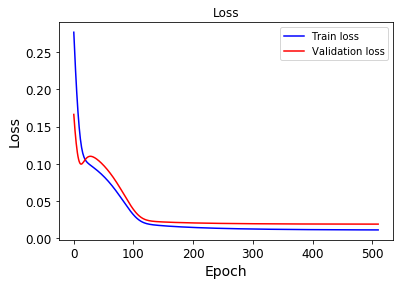

Epoch  0 / 2000 :  	Training Loss: 0.22277 	Validation Loss: 0.17978
Epoch  50 / 2000 :  	Training Loss: 0.03185 	Validation Loss: 0.02893
Epoch  100 / 2000 :  	Training Loss: 0.01840 	Validation Loss: 0.01698
Epoch  150 / 2000 :  	Training Loss: 0.01660 	Validation Loss: 0.01552
Epoch  200 / 2000 :  	Training Loss: 0.01579 	Validation Loss: 0.01485
Epoch  250 / 2000 :  	Training Loss: 0.01539 	Validation Loss: 0.01452
Epoch  300 / 2000 :  	Training Loss: 0.01519 	Validation Loss: 0.01436
Epoch  350 / 2000 :  	Training Loss: 0.01509 	Validation Loss: 0.01429
Epoch  400 / 2000 :  	Training Loss: 0.01504 	Validation Loss: 0.01425
Early stopping


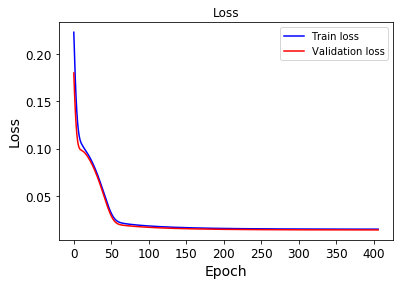

Epoch  0 / 2000 :  	Training Loss: 0.20202 	Validation Loss: 0.26799
Epoch  50 / 2000 :  	Training Loss: 0.01992 	Validation Loss: 0.01920
Epoch  100 / 2000 :  	Training Loss: 0.01636 	Validation Loss: 0.01426
Epoch  150 / 2000 :  	Training Loss: 0.01528 	Validation Loss: 0.01275
Epoch  200 / 2000 :  	Training Loss: 0.01491 	Validation Loss: 0.01219
Epoch  250 / 2000 :  	Training Loss: 0.01478 	Validation Loss: 0.01198
Epoch  300 / 2000 :  	Training Loss: 0.01473 	Validation Loss: 0.01189
Epoch  350 / 2000 :  	Training Loss: 0.01471 	Validation Loss: 0.01184
Early stopping


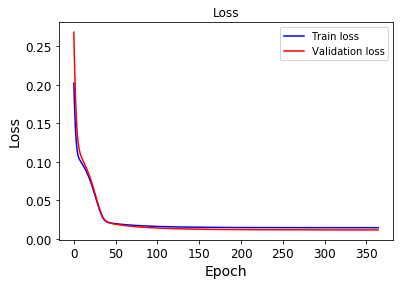

Epoch  0 / 2000 :  	Training Loss: 0.19740 	Validation Loss: 0.18144
Epoch  50 / 2000 :  	Training Loss: 0.01732 	Validation Loss: 0.02127
Epoch  100 / 2000 :  	Training Loss: 0.01472 	Validation Loss: 0.01915
Epoch  150 / 2000 :  	Training Loss: 0.01416 	Validation Loss: 0.01875
Epoch  200 / 2000 :  	Training Loss: 0.01402 	Validation Loss: 0.01868
Early stopping


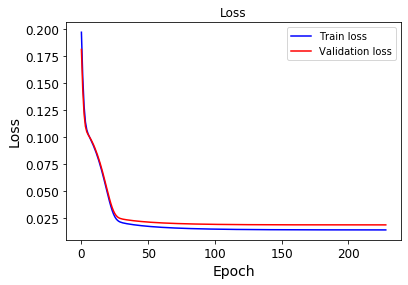

Epoch  0 / 2000 :  	Training Loss: 0.17154 	Validation Loss: 0.13344
Epoch  50 / 2000 :  	Training Loss: 0.01716 	Validation Loss: 0.01514
Epoch  100 / 2000 :  	Training Loss: 0.01530 	Validation Loss: 0.01354
Epoch  150 / 2000 :  	Training Loss: 0.01499 	Validation Loss: 0.01326
Epoch  200 / 2000 :  	Training Loss: 0.01493 	Validation Loss: 0.01320
Early stopping


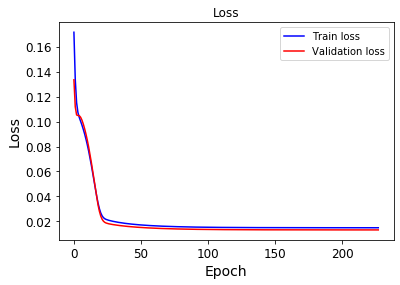

Epoch  0 / 2000 :  	Training Loss: 0.26749 	Validation Loss: 0.16079
Epoch  50 / 2000 :  	Training Loss: 0.06105 	Validation Loss: 0.07289
Epoch  100 / 2000 :  	Training Loss: 0.02122 	Validation Loss: 0.02480
Epoch  150 / 2000 :  	Training Loss: 0.01609 	Validation Loss: 0.02179
Epoch  200 / 2000 :  	Training Loss: 0.01380 	Validation Loss: 0.02056
Epoch  250 / 2000 :  	Training Loss: 0.01264 	Validation Loss: 0.01996
Epoch  300 / 2000 :  	Training Loss: 0.01201 	Validation Loss: 0.01966
Epoch  350 / 2000 :  	Training Loss: 0.01169 	Validation Loss: 0.01953
Epoch  400 / 2000 :  	Training Loss: 0.01152 	Validation Loss: 0.01949
Early stopping


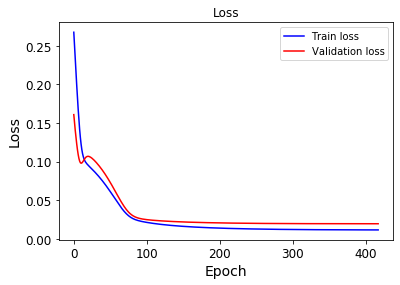

Epoch  0 / 2000 :  	Training Loss: 0.20070 	Validation Loss: 0.16184
Epoch  50 / 2000 :  	Training Loss: 0.02378 	Validation Loss: 0.02129
Epoch  100 / 2000 :  	Training Loss: 0.01783 	Validation Loss: 0.01652
Epoch  150 / 2000 :  	Training Loss: 0.01609 	Validation Loss: 0.01509
Epoch  200 / 2000 :  	Training Loss: 0.01547 	Validation Loss: 0.01458
Epoch  250 / 2000 :  	Training Loss: 0.01526 	Validation Loss: 0.01441
Epoch  300 / 2000 :  	Training Loss: 0.01520 	Validation Loss: 0.01436
Early stopping


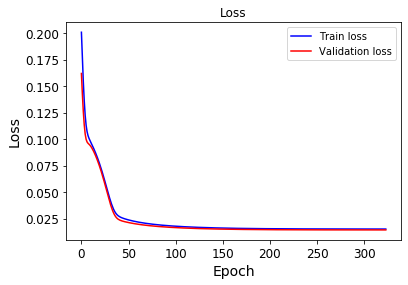

Epoch  0 / 2000 :  	Training Loss: 0.20022 	Validation Loss: 0.26561
Epoch  50 / 2000 :  	Training Loss: 0.01945 	Validation Loss: 0.01854
Epoch  100 / 2000 :  	Training Loss: 0.01580 	Validation Loss: 0.01343
Epoch  150 / 2000 :  	Training Loss: 0.01505 	Validation Loss: 0.01231
Epoch  200 / 2000 :  	Training Loss: 0.01491 	Validation Loss: 0.01206
Epoch  250 / 2000 :  	Training Loss: 0.01488 	Validation Loss: 0.01200
Early stopping


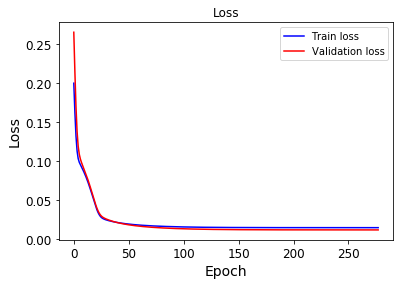

Epoch  0 / 2000 :  	Training Loss: 0.17056 	Validation Loss: 0.15742
Epoch  50 / 2000 :  	Training Loss: 0.01661 	Validation Loss: 0.02072
Epoch  100 / 2000 :  	Training Loss: 0.01439 	Validation Loss: 0.01898
Epoch  150 / 2000 :  	Training Loss: 0.01417 	Validation Loss: 0.01889
Early stopping


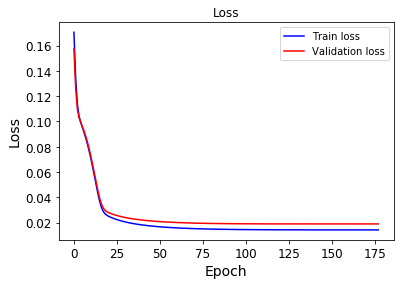

Epoch  0 / 2000 :  	Training Loss: 0.17353 	Validation Loss: 0.13464
Epoch  50 / 2000 :  	Training Loss: 0.01656 	Validation Loss: 0.01463
Epoch  100 / 2000 :  	Training Loss: 0.01517 	Validation Loss: 0.01340
Epoch  150 / 2000 :  	Training Loss: 0.01509 	Validation Loss: 0.01332
Early stopping


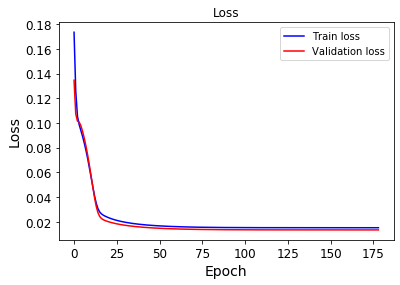

Epoch  0 / 2000 :  	Training Loss: 0.27578 	Validation Loss: 0.16586
Epoch  50 / 2000 :  	Training Loss: 0.03412 	Validation Loss: 0.03661
Epoch  100 / 2000 :  	Training Loss: 0.01783 	Validation Loss: 0.02280
Epoch  150 / 2000 :  	Training Loss: 0.01382 	Validation Loss: 0.02060
Epoch  200 / 2000 :  	Training Loss: 0.01231 	Validation Loss: 0.01984
Epoch  250 / 2000 :  	Training Loss: 0.01172 	Validation Loss: 0.01962
Epoch  300 / 2000 :  	Training Loss: 0.01152 	Validation Loss: 0.01960
Early stopping


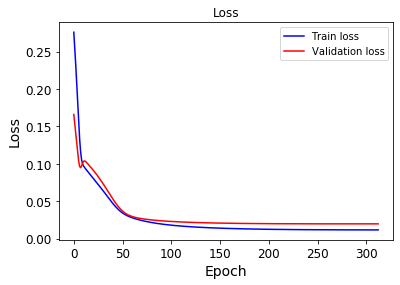

Epoch  0 / 2000 :  	Training Loss: 0.23557 	Validation Loss: 0.19041
Epoch  50 / 2000 :  	Training Loss: 0.02166 	Validation Loss: 0.01959
Epoch  100 / 2000 :  	Training Loss: 0.01649 	Validation Loss: 0.01540
Epoch  150 / 2000 :  	Training Loss: 0.01546 	Validation Loss: 0.01456
Epoch  200 / 2000 :  	Training Loss: 0.01530 	Validation Loss: 0.01443
Early stopping


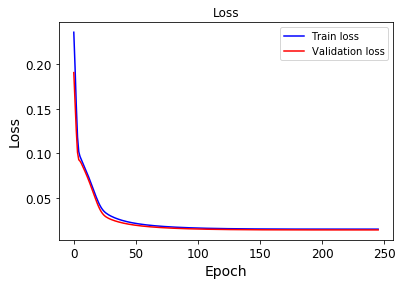

Epoch  0 / 2000 :  	Training Loss: 0.19223 	Validation Loss: 0.25499
Epoch  50 / 2000 :  	Training Loss: 0.01769 	Validation Loss: 0.01610
Epoch  100 / 2000 :  	Training Loss: 0.01517 	Validation Loss: 0.01245
Epoch  150 / 2000 :  	Training Loss: 0.01499 	Validation Loss: 0.01211
Epoch  200 / 2000 :  	Training Loss: 0.01497 	Validation Loss: 0.01208
Early stopping


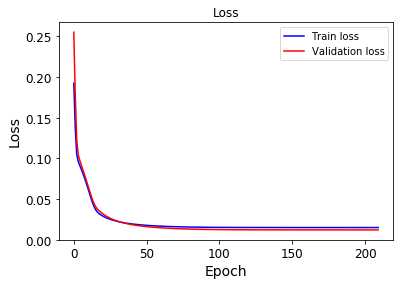

Epoch  0 / 2000 :  	Training Loss: 0.17326 	Validation Loss: 0.15968
Epoch  50 / 2000 :  	Training Loss: 0.01531 	Validation Loss: 0.01966
Epoch  100 / 2000 :  	Training Loss: 0.01426 	Validation Loss: 0.01900
Early stopping


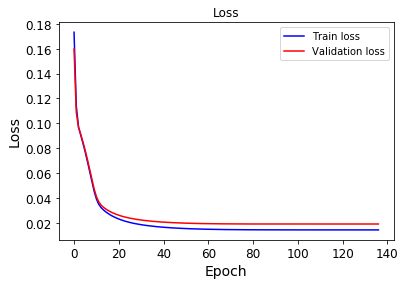

Epoch  0 / 2000 :  	Training Loss: 0.15795 	Validation Loss: 0.12456
Epoch  50 / 2000 :  	Training Loss: 0.01562 	Validation Loss: 0.01384
Epoch  100 / 2000 :  	Training Loss: 0.01520 	Validation Loss: 0.01341
Epoch  150 / 2000 :  	Training Loss: 0.01517 	Validation Loss: 0.01338
Early stopping


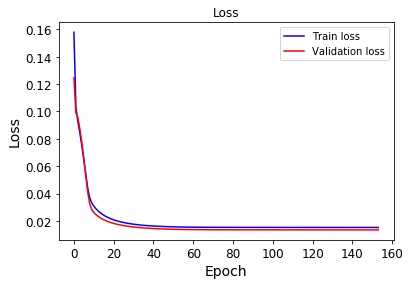

Epoch  0 / 2000 :  	Training Loss: 0.25504 	Validation Loss: 0.15332
Epoch  50 / 2000 :  	Training Loss: 0.02619 	Validation Loss: 0.02794
Epoch  100 / 2000 :  	Training Loss: 0.01479 	Validation Loss: 0.02123
Epoch  150 / 2000 :  	Training Loss: 0.01233 	Validation Loss: 0.02016
Epoch  200 / 2000 :  	Training Loss: 0.01175 	Validation Loss: 0.01995
Epoch  250 / 2000 :  	Training Loss: 0.01157 	Validation Loss: 0.01983
Epoch  300 / 2000 :  	Training Loss: 0.01150 	Validation Loss: 0.01977
Early stopping


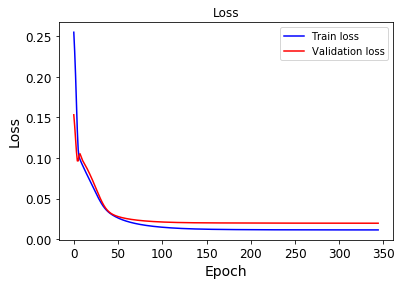

Epoch  0 / 2000 :  	Training Loss: 0.19671 	Validation Loss: 0.15866
Epoch  50 / 2000 :  	Training Loss: 0.01861 	Validation Loss: 0.01716
Epoch  100 / 2000 :  	Training Loss: 0.01595 	Validation Loss: 0.01491
Epoch  150 / 2000 :  	Training Loss: 0.01538 	Validation Loss: 0.01445
Epoch  200 / 2000 :  	Training Loss: 0.01527 	Validation Loss: 0.01440
Early stopping


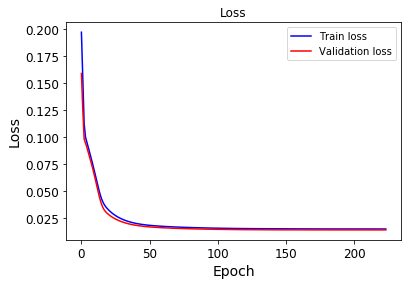

Epoch  0 / 2000 :  	Training Loss: 0.17081 	Validation Loss: 0.22592
Epoch  50 / 2000 :  	Training Loss: 0.01622 	Validation Loss: 0.01392
Epoch  100 / 2000 :  	Training Loss: 0.01506 	Validation Loss: 0.01219
Epoch  150 / 2000 :  	Training Loss: 0.01499 	Validation Loss: 0.01210
Early stopping


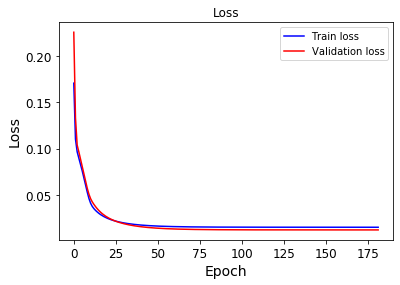

Epoch  0 / 2000 :  	Training Loss: 0.17830 	Validation Loss: 0.16408
Epoch  50 / 2000 :  	Training Loss: 0.01466 	Validation Loss: 0.01930
Epoch  100 / 2000 :  	Training Loss: 0.01425 	Validation Loss: 0.01901
Epoch  150 / 2000 :  	Training Loss: 0.01423 	Validation Loss: 0.01895
Early stopping


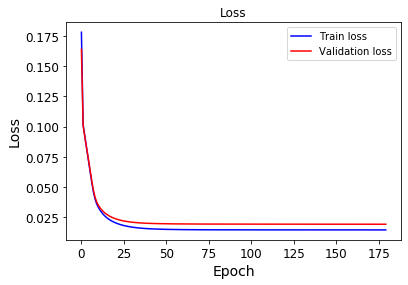

Epoch  0 / 2000 :  	Training Loss: 0.13140 	Validation Loss: 0.10886
Epoch  50 / 2000 :  	Training Loss: 0.01543 	Validation Loss: 0.01365
Epoch  100 / 2000 :  	Training Loss: 0.01518 	Validation Loss: 0.01338
Early stopping


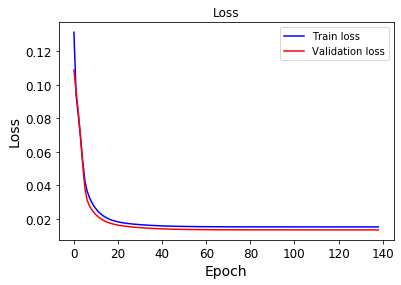

Epoch  0 / 2000 :  	Training Loss: 0.29244 	Validation Loss: 0.17634
Epoch  50 / 2000 :  	Training Loss: 0.01860 	Validation Loss: 0.02351
Epoch  100 / 2000 :  	Training Loss: 0.01345 	Validation Loss: 0.02129
Epoch  150 / 2000 :  	Training Loss: 0.01208 	Validation Loss: 0.02027
Epoch  200 / 2000 :  	Training Loss: 0.01162 	Validation Loss: 0.01986
Epoch  250 / 2000 :  	Training Loss: 0.01150 	Validation Loss: 0.01971
Epoch  300 / 2000 :  	Training Loss: 0.01147 	Validation Loss: 0.01966
Early stopping


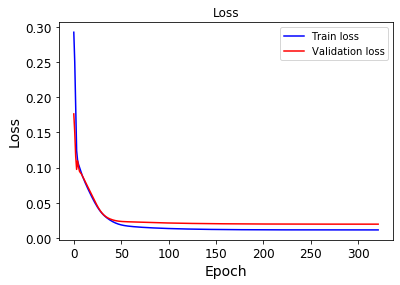

Epoch  0 / 2000 :  	Training Loss: 0.19274 	Validation Loss: 0.15555
Epoch  50 / 2000 :  	Training Loss: 0.01762 	Validation Loss: 0.01626
Epoch  100 / 2000 :  	Training Loss: 0.01560 	Validation Loss: 0.01460
Epoch  150 / 2000 :  	Training Loss: 0.01529 	Validation Loss: 0.01438
Early stopping


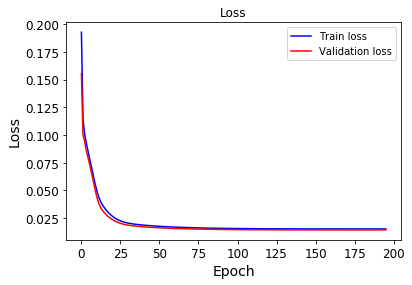

Epoch  0 / 2000 :  	Training Loss: 0.14903 	Validation Loss: 0.19523
Epoch  50 / 2000 :  	Training Loss: 0.01595 	Validation Loss: 0.01334
Epoch  100 / 2000 :  	Training Loss: 0.01498 	Validation Loss: 0.01214
Epoch  150 / 2000 :  	Training Loss: 0.01494 	Validation Loss: 0.01211
Early stopping


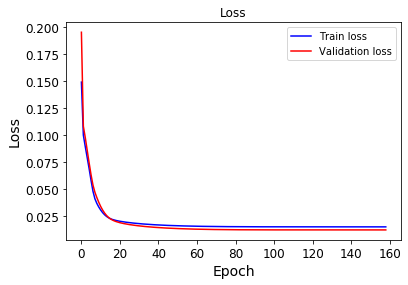

Epoch  0 / 2000 :  	Training Loss: 0.13753 	Validation Loss: 0.12814
Epoch  50 / 2000 :  	Training Loss: 0.01441 	Validation Loss: 0.01914
Epoch  100 / 2000 :  	Training Loss: 0.01420 	Validation Loss: 0.01899
Epoch  150 / 2000 :  	Training Loss: 0.01416 	Validation Loss: 0.01892
Epoch  200 / 2000 :  	Training Loss: 0.01408 	Validation Loss: 0.01881
Epoch  250 / 2000 :  	Training Loss: 0.01395 	Validation Loss: 0.01865
Epoch  300 / 2000 :  	Training Loss: 0.01374 	Validation Loss: 0.01837
Epoch  350 / 2000 :  	Training Loss: 0.01358 	Validation Loss: 0.01813
Epoch  400 / 2000 :  	Training Loss: 0.01344 	Validation Loss: 0.01794
Epoch  450 / 2000 :  	Training Loss: 0.01321 	Validation Loss: 0.01762
Epoch  500 / 2000 :  	Training Loss: 0.01280 	Validation Loss: 0.01701
Epoch  550 / 2000 :  	Training Loss: 0.01258 	Validation Loss: 0.01670
Epoch  600 / 2000 :  	Training Loss: 0.01238 	Validation Loss: 0.01640
Epoch  650 / 2000 :  	Training Loss: 0.01213 	Validation Loss: 0.01602
Epoch  70

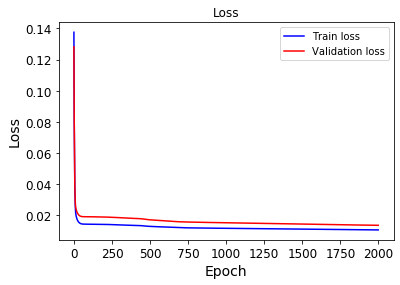

Epoch  0 / 2000 :  	Training Loss: 0.10417 	Validation Loss: 0.10173
Epoch  50 / 2000 :  	Training Loss: 0.01521 	Validation Loss: 0.01344
Epoch  100 / 2000 :  	Training Loss: 0.01512 	Validation Loss: 0.01335
Epoch  150 / 2000 :  	Training Loss: 0.01502 	Validation Loss: 0.01327
Epoch  200 / 2000 :  	Training Loss: 0.01486 	Validation Loss: 0.01315
Epoch  250 / 2000 :  	Training Loss: 0.01465 	Validation Loss: 0.01300
Epoch  300 / 2000 :  	Training Loss: 0.01449 	Validation Loss: 0.01289
Epoch  350 / 2000 :  	Training Loss: 0.01439 	Validation Loss: 0.01282
Epoch  400 / 2000 :  	Training Loss: 0.01429 	Validation Loss: 0.01274
Epoch  450 / 2000 :  	Training Loss: 0.01408 	Validation Loss: 0.01260
Epoch  500 / 2000 :  	Training Loss: 0.01349 	Validation Loss: 0.01212
Epoch  550 / 2000 :  	Training Loss: 0.01319 	Validation Loss: 0.01189
Epoch  600 / 2000 :  	Training Loss: 0.01299 	Validation Loss: 0.01173
Epoch  650 / 2000 :  	Training Loss: 0.01280 	Validation Loss: 0.01159
Epoch  70

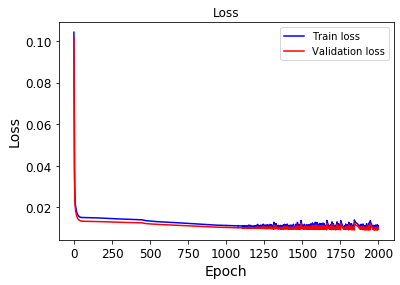

In [0]:
n_splits = 5
tscv = TimeSeriesSplit(n_splits)
hidden_sizes=[1,2,5,10,20]
i=0
val_losses=[]
batch_size  = 100
max_epochs = 2000
input_dimensions=1
for hidden_size in hidden_sizes:
 val_loss =0
 for train_fold, test_fold in tscv.split(x_train_reg):
  x_train, x_test = x_train_reg[train_fold], x_train_reg[test_fold]
  y_train, y_test = y_train_reg[train_fold], y_train_reg[test_fold]
  session = tf.Session()
  # Add an additional layer on top of each of the hidden state outputs
  alpharnn_t = alphaRNN(input_dimensions, hidden_size)
  #models.append(train(alpharnn_t, x_train, x_test, y_train, y_test)) 
  model, val_loss_=train(session, alpharnn_t, x_train, x_test, y_train, y_test, max_epochs=2000, batch_size =int(batch_size/n_splits))
  val_loss+=val_loss_
 val_losses.append(val_loss)
  
  

Epoch  0 / 2000 :  	Training Loss: 0.27658 	Validation Loss: 0.16635
Epoch  50 / 2000 :  	Training Loss: 0.08613 	Validation Loss: 0.09987
Epoch  100 / 2000 :  	Training Loss: 0.03272 	Validation Loss: 0.03817
Epoch  150 / 2000 :  	Training Loss: 0.01859 	Validation Loss: 0.02333
Epoch  200 / 2000 :  	Training Loss: 0.01531 	Validation Loss: 0.02143
Epoch  250 / 2000 :  	Training Loss: 0.01364 	Validation Loss: 0.02047
Epoch  300 / 2000 :  	Training Loss: 0.01269 	Validation Loss: 0.01994
Epoch  350 / 2000 :  	Training Loss: 0.01212 	Validation Loss: 0.01963
Epoch  400 / 2000 :  	Training Loss: 0.01179 	Validation Loss: 0.01946
Epoch  450 / 2000 :  	Training Loss: 0.01158 	Validation Loss: 0.01937
Epoch  500 / 2000 :  	Training Loss: 0.01147 	Validation Loss: 0.01934
Early stopping


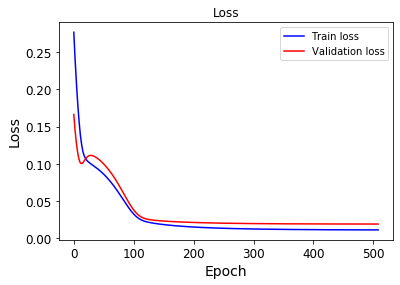

Epoch  0 / 2000 :  	Training Loss: 0.23887 	Validation Loss: 0.19312
Epoch  50 / 2000 :  	Training Loss: 0.03346 	Validation Loss: 0.02985
Epoch  100 / 2000 :  	Training Loss: 0.01920 	Validation Loss: 0.01764
Epoch  150 / 2000 :  	Training Loss: 0.01673 	Validation Loss: 0.01562
Epoch  200 / 2000 :  	Training Loss: 0.01575 	Validation Loss: 0.01481
Epoch  250 / 2000 :  	Training Loss: 0.01533 	Validation Loss: 0.01447
Epoch  300 / 2000 :  	Training Loss: 0.01516 	Validation Loss: 0.01433
Epoch  350 / 2000 :  	Training Loss: 0.01509 	Validation Loss: 0.01428
Early stopping


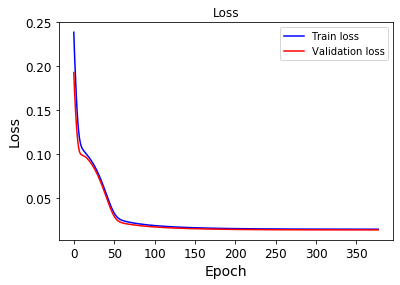

Epoch  0 / 2000 :  	Training Loss: 0.18879 	Validation Loss: 0.25036
Epoch  50 / 2000 :  	Training Loss: 0.05100 	Validation Loss: 0.05287
Epoch  100 / 2000 :  	Training Loss: 0.03906 	Validation Loss: 0.03933
Epoch  150 / 2000 :  	Training Loss: 0.02253 	Validation Loss: 0.02096
Epoch  200 / 2000 :  	Training Loss: 0.01668 	Validation Loss: 0.01423
Epoch  250 / 2000 :  	Training Loss: 0.01539 	Validation Loss: 0.01265
Epoch  300 / 2000 :  	Training Loss: 0.01511 	Validation Loss: 0.01227
Epoch  350 / 2000 :  	Training Loss: 0.01507 	Validation Loss: 0.01219
Early stopping


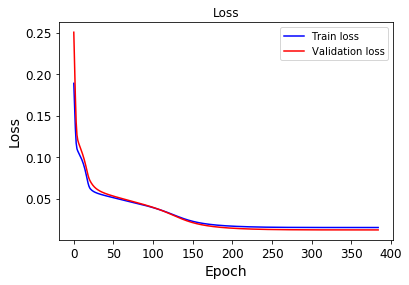

Epoch  0 / 2000 :  	Training Loss: 0.19858 	Validation Loss: 0.18252
Epoch  50 / 2000 :  	Training Loss: 0.01806 	Validation Loss: 0.02202
Epoch  100 / 2000 :  	Training Loss: 0.01468 	Validation Loss: 0.01917
Epoch  150 / 2000 :  	Training Loss: 0.01413 	Validation Loss: 0.01878
Epoch  200 / 2000 :  	Training Loss: 0.01405 	Validation Loss: 0.01875
Early stopping


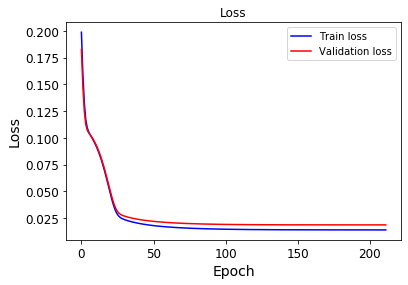

Epoch  0 / 2000 :  	Training Loss: 0.18695 	Validation Loss: 0.14364
Epoch  50 / 2000 :  	Training Loss: 0.04430 	Validation Loss: 0.04357
Epoch  100 / 2000 :  	Training Loss: 0.01969 	Validation Loss: 0.01807
Epoch  150 / 2000 :  	Training Loss: 0.01560 	Validation Loss: 0.01380
Epoch  200 / 2000 :  	Training Loss: 0.01529 	Validation Loss: 0.01347
Early stopping


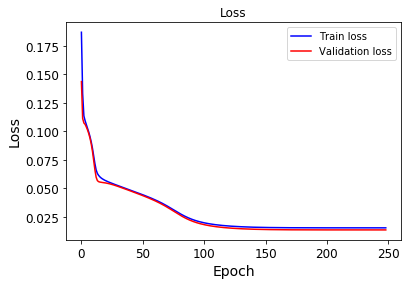

Epoch  0 / 2000 :  	Training Loss: 0.26826 	Validation Loss: 0.16125
Epoch  50 / 2000 :  	Training Loss: 0.07427 	Validation Loss: 0.07572
Epoch  100 / 2000 :  	Training Loss: 0.04840 	Validation Loss: 0.05534
Epoch  150 / 2000 :  	Training Loss: 0.04064 	Validation Loss: 0.04991
Epoch  200 / 2000 :  	Training Loss: 0.03001 	Validation Loss: 0.03955
Epoch  250 / 2000 :  	Training Loss: 0.02067 	Validation Loss: 0.02894
Epoch  300 / 2000 :  	Training Loss: 0.01781 	Validation Loss: 0.02610
Epoch  350 / 2000 :  	Training Loss: 0.01515 	Validation Loss: 0.02333
Epoch  400 / 2000 :  	Training Loss: 0.01330 	Validation Loss: 0.02139
Epoch  450 / 2000 :  	Training Loss: 0.01229 	Validation Loss: 0.02033
Epoch  500 / 2000 :  	Training Loss: 0.01179 	Validation Loss: 0.01983
Epoch  550 / 2000 :  	Training Loss: 0.01156 	Validation Loss: 0.01966
Epoch  600 / 2000 :  	Training Loss: 0.01149 	Validation Loss: 0.01962
Early stopping


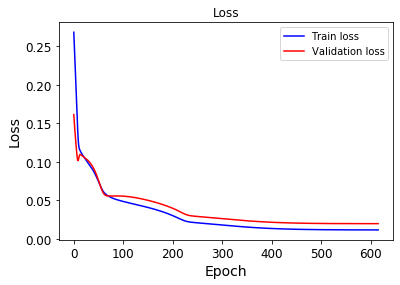

Epoch  0 / 2000 :  	Training Loss: 0.21456 	Validation Loss: 0.17304
Epoch  50 / 2000 :  	Training Loss: 0.03729 	Validation Loss: 0.03475
Epoch  100 / 2000 :  	Training Loss: 0.01903 	Validation Loss: 0.01749
Epoch  150 / 2000 :  	Training Loss: 0.01631 	Validation Loss: 0.01521
Epoch  200 / 2000 :  	Training Loss: 0.01551 	Validation Loss: 0.01457
Epoch  250 / 2000 :  	Training Loss: 0.01521 	Validation Loss: 0.01436
Epoch  300 / 2000 :  	Training Loss: 0.01510 	Validation Loss: 0.01428
Early stopping


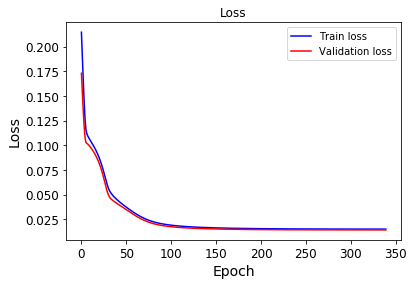

Epoch  0 / 2000 :  	Training Loss: 0.17905 	Validation Loss: 0.23713
Epoch  50 / 2000 :  	Training Loss: 0.02066 	Validation Loss: 0.01982
Epoch  100 / 2000 :  	Training Loss: 0.01575 	Validation Loss: 0.01330
Epoch  150 / 2000 :  	Training Loss: 0.01500 	Validation Loss: 0.01221
Epoch  200 / 2000 :  	Training Loss: 0.01492 	Validation Loss: 0.01205
Epoch  250 / 2000 :  	Training Loss: 0.01491 	Validation Loss: 0.01203
Early stopping


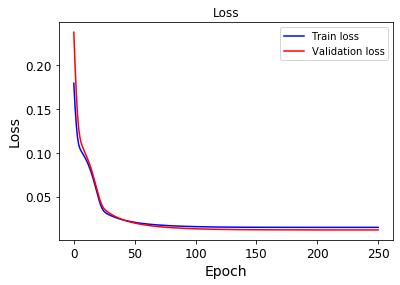

Epoch  0 / 2000 :  	Training Loss: 0.19452 	Validation Loss: 0.17886
Epoch  50 / 2000 :  	Training Loss: 0.01713 	Validation Loss: 0.02126
Epoch  100 / 2000 :  	Training Loss: 0.01435 	Validation Loss: 0.01898
Epoch  150 / 2000 :  	Training Loss: 0.01418 	Validation Loss: 0.01892
Early stopping


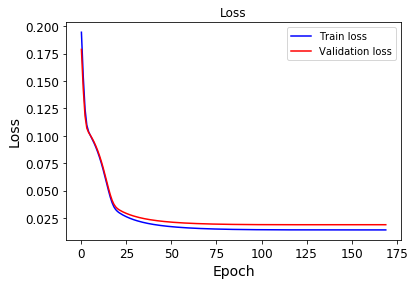

Epoch  0 / 2000 :  	Training Loss: 0.16702 	Validation Loss: 0.13062
Epoch  50 / 2000 :  	Training Loss: 0.01684 	Validation Loss: 0.01496
Epoch  100 / 2000 :  	Training Loss: 0.01513 	Validation Loss: 0.01336
Epoch  150 / 2000 :  	Training Loss: 0.01498 	Validation Loss: 0.01323
Early stopping


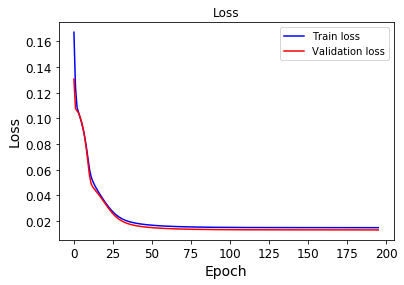

Epoch  0 / 2000 :  	Training Loss: 0.26555 	Validation Loss: 0.15961
Epoch  50 / 2000 :  	Training Loss: 0.04903 	Validation Loss: 0.04964
Epoch  100 / 2000 :  	Training Loss: 0.02214 	Validation Loss: 0.02978
Epoch  150 / 2000 :  	Training Loss: 0.01539 	Validation Loss: 0.02290
Epoch  200 / 2000 :  	Training Loss: 0.01300 	Validation Loss: 0.02080
Epoch  250 / 2000 :  	Training Loss: 0.01202 	Validation Loss: 0.02003
Epoch  300 / 2000 :  	Training Loss: 0.01162 	Validation Loss: 0.01975
Epoch  350 / 2000 :  	Training Loss: 0.01148 	Validation Loss: 0.01966
Early stopping


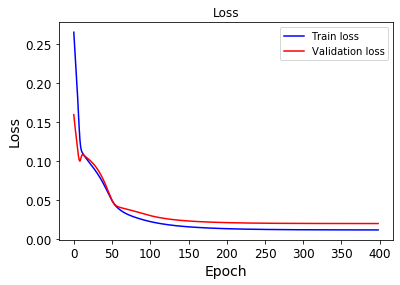

Epoch  0 / 2000 :  	Training Loss: 0.19679 	Validation Loss: 0.15870
Epoch  50 / 2000 :  	Training Loss: 0.02608 	Validation Loss: 0.02396
Epoch  100 / 2000 :  	Training Loss: 0.01701 	Validation Loss: 0.01578
Epoch  150 / 2000 :  	Training Loss: 0.01557 	Validation Loss: 0.01466
Epoch  200 / 2000 :  	Training Loss: 0.01526 	Validation Loss: 0.01442
Epoch  250 / 2000 :  	Training Loss: 0.01519 	Validation Loss: 0.01435
Early stopping


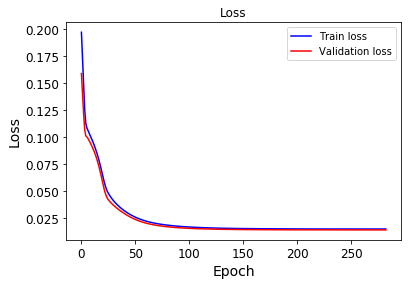

Epoch  0 / 2000 :  	Training Loss: 0.17224 	Validation Loss: 0.22773
Epoch  50 / 2000 :  	Training Loss: 0.02105 	Validation Loss: 0.01940
Epoch  100 / 2000 :  	Training Loss: 0.01558 	Validation Loss: 0.01301
Epoch  150 / 2000 :  	Training Loss: 0.01492 	Validation Loss: 0.01214
Epoch  200 / 2000 :  	Training Loss: 0.01477 	Validation Loss: 0.01194
Epoch  250 / 2000 :  	Training Loss: 0.01472 	Validation Loss: 0.01188
Early stopping


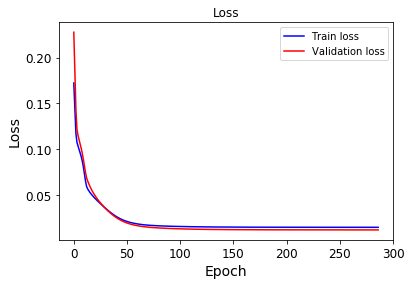

Epoch  0 / 2000 :  	Training Loss: 0.17828 	Validation Loss: 0.16429
Epoch  50 / 2000 :  	Training Loss: 0.01630 	Validation Loss: 0.02077
Epoch  100 / 2000 :  	Training Loss: 0.01420 	Validation Loss: 0.01890
Epoch  150 / 2000 :  	Training Loss: 0.01416 	Validation Loss: 0.01888
Early stopping


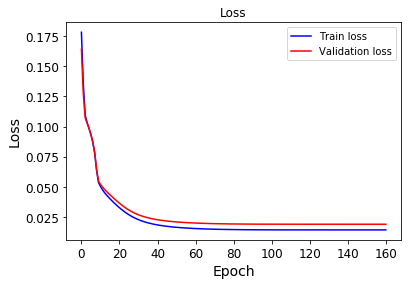

Epoch  0 / 2000 :  	Training Loss: 0.16481 	Validation Loss: 0.12911
Epoch  50 / 2000 :  	Training Loss: 0.01583 	Validation Loss: 0.01401
Epoch  100 / 2000 :  	Training Loss: 0.01517 	Validation Loss: 0.01339
Epoch  150 / 2000 :  	Training Loss: 0.01510 	Validation Loss: 0.01331
Early stopping


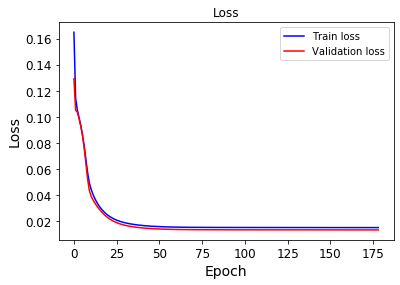

Epoch  0 / 2000 :  	Training Loss: 0.25679 	Validation Loss: 0.15437
Epoch  50 / 2000 :  	Training Loss: 0.03790 	Validation Loss: 0.04064
Epoch  100 / 2000 :  	Training Loss: 0.01918 	Validation Loss: 0.02655
Epoch  150 / 2000 :  	Training Loss: 0.01393 	Validation Loss: 0.02155
Epoch  200 / 2000 :  	Training Loss: 0.01220 	Validation Loss: 0.02016
Epoch  250 / 2000 :  	Training Loss: 0.01162 	Validation Loss: 0.01974
Epoch  300 / 2000 :  	Training Loss: 0.01146 	Validation Loss: 0.01964
Early stopping


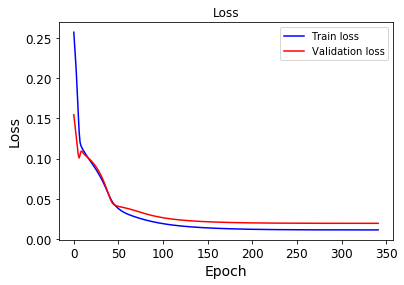

Epoch  0 / 2000 :  	Training Loss: 0.19480 	Validation Loss: 0.15712
Epoch  50 / 2000 :  	Training Loss: 0.02400 	Validation Loss: 0.02198
Epoch  100 / 2000 :  	Training Loss: 0.01644 	Validation Loss: 0.01535
Epoch  150 / 2000 :  	Training Loss: 0.01533 	Validation Loss: 0.01444
Epoch  200 / 2000 :  	Training Loss: 0.01521 	Validation Loss: 0.01436
Early stopping


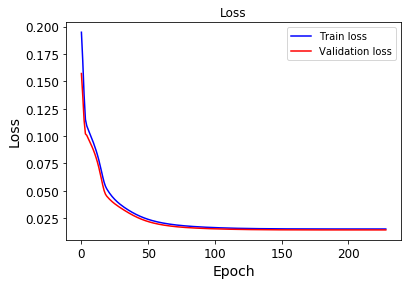

Epoch  0 / 2000 :  	Training Loss: 0.17380 	Validation Loss: 0.22992
Epoch  50 / 2000 :  	Training Loss: 0.01863 	Validation Loss: 0.01688
Epoch  100 / 2000 :  	Training Loss: 0.01504 	Validation Loss: 0.01228
Epoch  150 / 2000 :  	Training Loss: 0.01491 	Validation Loss: 0.01208
Early stopping


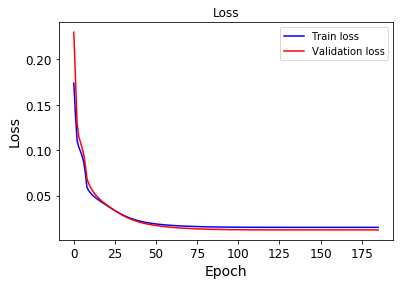

Epoch  0 / 2000 :  	Training Loss: 0.20386 	Validation Loss: 0.18725
Epoch  50 / 2000 :  	Training Loss: 0.01525 	Validation Loss: 0.01979
Epoch  100 / 2000 :  	Training Loss: 0.01418 	Validation Loss: 0.01890
Early stopping


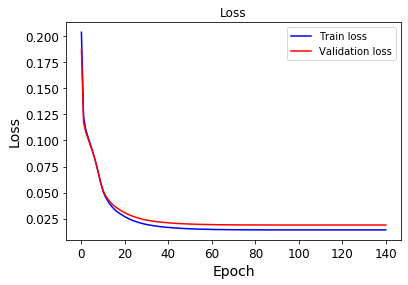

Epoch  0 / 2000 :  	Training Loss: 0.16155 	Validation Loss: 0.12686
Epoch  50 / 2000 :  	Training Loss: 0.01557 	Validation Loss: 0.01374
Epoch  100 / 2000 :  	Training Loss: 0.01512 	Validation Loss: 0.01333
Early stopping


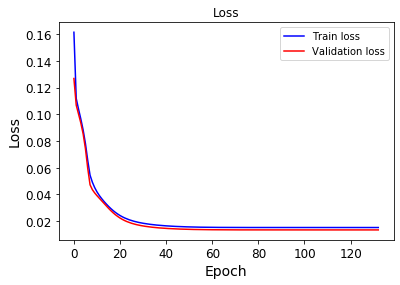

Epoch  0 / 2000 :  	Training Loss: 0.29251 	Validation Loss: 0.17634
Epoch  50 / 2000 :  	Training Loss: 0.03230 	Validation Loss: 0.03891
Epoch  100 / 2000 :  	Training Loss: 0.01578 	Validation Loss: 0.02290
Epoch  150 / 2000 :  	Training Loss: 0.01220 	Validation Loss: 0.02018
Epoch  200 / 2000 :  	Training Loss: 0.01159 	Validation Loss: 0.01974
Epoch  250 / 2000 :  	Training Loss: 0.01146 	Validation Loss: 0.01964
Early stopping


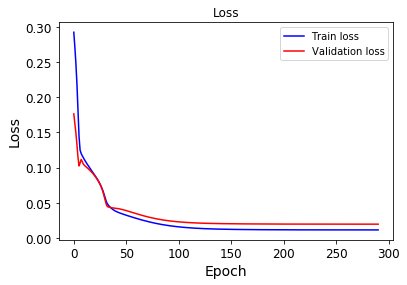

Epoch  0 / 2000 :  	Training Loss: 0.21247 	Validation Loss: 0.17135
Epoch  50 / 2000 :  	Training Loss: 0.02155 	Validation Loss: 0.01949
Epoch  100 / 2000 :  	Training Loss: 0.01552 	Validation Loss: 0.01458
Epoch  150 / 2000 :  	Training Loss: 0.01523 	Validation Loss: 0.01436
Early stopping


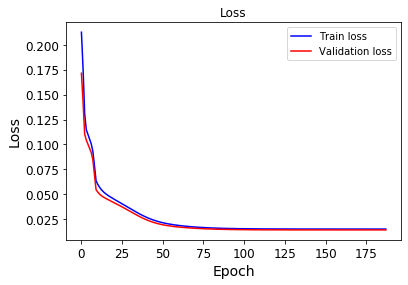

Epoch  0 / 2000 :  	Training Loss: 0.17924 	Validation Loss: 0.23744
Epoch  50 / 2000 :  	Training Loss: 0.01626 	Validation Loss: 0.01384
Epoch  100 / 2000 :  	Training Loss: 0.01495 	Validation Loss: 0.01214
Epoch  150 / 2000 :  	Training Loss: 0.01492 	Validation Loss: 0.01209
Early stopping


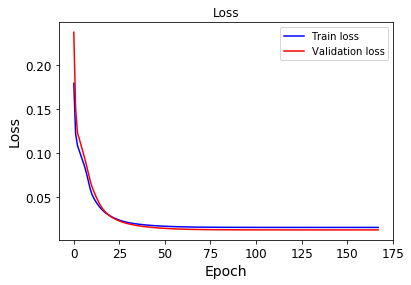

Epoch  0 / 2000 :  	Training Loss: 0.17234 	Validation Loss: 0.15887
Epoch  50 / 2000 :  	Training Loss: 0.01450 	Validation Loss: 0.01916
Epoch  100 / 2000 :  	Training Loss: 0.01420 	Validation Loss: 0.01891
Early stopping


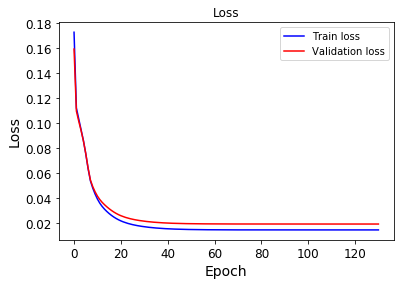

Epoch  0 / 2000 :  	Training Loss: 0.15770 	Validation Loss: 0.12436
Epoch  50 / 2000 :  	Training Loss: 0.01530 	Validation Loss: 0.01353
Epoch  100 / 2000 :  	Training Loss: 0.01514 	Validation Loss: 0.01334
Early stopping


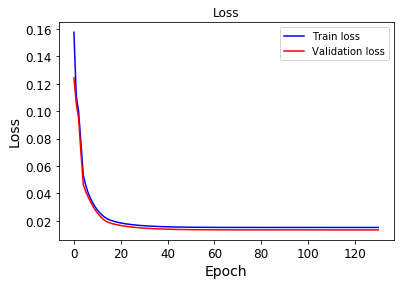

In [0]:
n_splits = 5
tscv = TimeSeriesSplit(n_splits)
hidden_sizes=[1,2,5,10,20]
i=0
val_losses2=[]
batch_size  = int(100/n_splits)
max_epochs = 2000
input_dimensions=1
for hidden_size in hidden_sizes:
 val_loss =0
 for train_fold, test_fold in tscv.split(x_train_reg):
  x_train, x_test = x_train_reg[train_fold], x_train_reg[test_fold]
  y_train, y_test = y_train_reg[train_fold], y_train_reg[test_fold]
  session = tf.Session()
  # Add an additional layer on top of each of the hidden state outputs
  alpharnn = simpleAlphaRNN(input_dimensions, hidden_size)
  #models.append(train(alpharnn_t, x_train, x_test, y_train, y_test)) 
  model, val_loss_=train(session, alpharnn, x_train, x_test, y_train, y_test, max_epochs, batch_size)
  val_loss+=val_loss_
 val_losses2.append(val_loss)
  
  

![alt text](https://)Pick the model with the lowest val loss sum over folds. you can *not* use the test set for model selection! This would be cheating


> Indented block



In [0]:
# SimpleRNN: Pick the model with the lowest val_loss. Retrain it on all data and then perform prediction
val, idx = min((val, idx) for (idx, val) in enumerate(val_losses2))
print(hidden_sizes[idx])

1


In [0]:
# AlphaRNN: Pick the model with the lowest val_loss. Retrain it on all data and then perform prediction
val, idx = min((val, idx) for (idx, val) in enumerate(val_losses))
print(hidden_sizes[idx])

20


### Train on all training data with best model and predict on test set (no rolling)

Epoch  0 / 2000 :  	Training Loss: 0.19528 	Validation Loss: 0.20226
Epoch  50 / 2000 :  	Training Loss: 0.05441 	Validation Loss: 0.05516
Epoch  100 / 2000 :  	Training Loss: 0.04062 	Validation Loss: 0.04063
Epoch  150 / 2000 :  	Training Loss: 0.02304 	Validation Loss: 0.02226
Epoch  200 / 2000 :  	Training Loss: 0.01675 	Validation Loss: 0.01558
Epoch  250 / 2000 :  	Training Loss: 0.01532 	Validation Loss: 0.01402
Epoch  300 / 2000 :  	Training Loss: 0.01500 	Validation Loss: 0.01366
Epoch  350 / 2000 :  	Training Loss: 0.01496 	Validation Loss: 0.01360
Early stopping


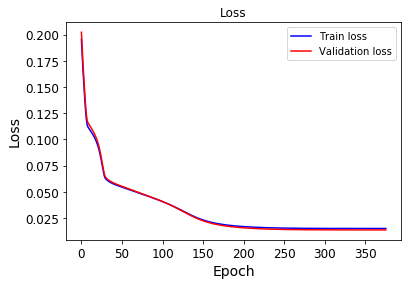

In [0]:
session = tf.Session()
alpharnn = simpleAlphaRNN(input_dimensions, hidden_sizes[idx])
model,_=train(session, alpharnn, x_train_reg, x_test_reg, y_train_reg, y_test_reg) 

Epoch  0 / 2000 :  	Training Loss: 0.18895 	Validation Loss: 0.19576
Epoch  50 / 2000 :  	Training Loss: 0.01644 	Validation Loss: 0.01529
Epoch  100 / 2000 :  	Training Loss: 0.01491 	Validation Loss: 0.01359
Epoch  150 / 2000 :  	Training Loss: 0.01483 	Validation Loss: 0.01348
Early stopping


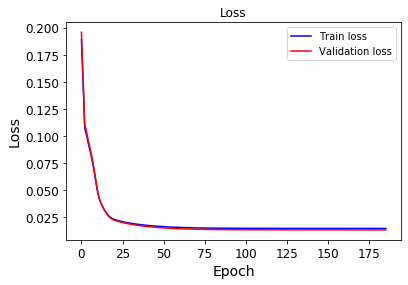

In [0]:
session = tf.Session()
alpharnn_t = alphaRNN(input_dimensions, hidden_sizes[idx])
model,_=train(session, alpharnn_t, x_train_reg, x_test_reg, y_train_reg, y_test_reg) 

In [0]:
y_predicted_t = session.run(model.output, feed_dict={model.input_layer: x_test_reg})
y_predicted_ar_t=np.array([0]*y_predicted_t.shape[0], dtype='float64')
for i in range(y_predicted_t.shape[0]):
     y_predicted_ar_t[i]=y_predicted_t[i][n_steps-1][0]

In [0]:
y_predicted_t = session.run(model.output, feed_dict={model.input_layer: x_train_reg})
y_predicted_train_t=np.array([0]*y_predicted_t.shape[0], dtype='float64')
for i in range(y_predicted_t.shape[0]):
     y_predicted_train_t[i]=y_predicted_t[i][n_steps-1][0]

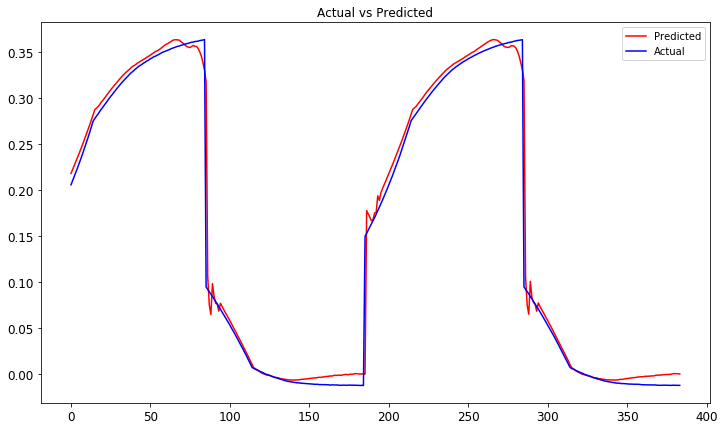

In [0]:
fig = plt.figure(figsize=(12,7))
plt.plot(y_predicted_ar_t, color='r', label='Predicted')
plt.plot(y_test_reg.flatten(),'b', label='Actual')
plt.legend(loc=0)
plt.title('Actual vs Predicted')
plt.show()

In [0]:
mse = mean_squared_error(y_test_reg[:,0],y_predicted_ar_t)
print(mse)

0.0004935575464085282


In [0]:
mse_std = np.math.sqrt(mse)
print(mse_std)

0.022216155077072364


In [0]:
y_predicted = session.run(model.output, feed_dict={model.input_layer: x_test_reg})
y_predicted_ar=np.array([0]*y_predicted.shape[0], dtype='float64')
for i in range(y_predicted.shape[0]):
     y_predicted_ar[i]=y_predicted[i][n_steps-1][0]

In [0]:
y_predicted = session.run(model.output, feed_dict={model.input_layer: x_train_reg})
y_predicted_train=np.array([0]*y_predicted.shape[0], dtype='float64')
for i in range(y_predicted.shape[0]):
     y_predicted_train[i]=y_predicted[i][n_steps-1][0]

In [0]:

se = mean_squared_error(y_test_reg[:,0],y_predicted_ar)
print(mse)
mse_std = np.math.sqrt(mse)
print(mse_std)

0.00042334075261903065
0.02057524611320678


#Comparison with Keras models


In [0]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU, SimpleRNN
from keras import optimizers
from keras.callbacks import EarlyStopping

In [0]:
x_train_reg = pd.concat(x_train_list, axis=1)
x_train_reg = x_train_reg.iloc[:, col_ords]
y_train_reg = df_train.loc[x_train_reg.index, [target]].values
x_train_reg = np.reshape(x_train_reg.values, (x_train_reg.shape[0], np.int(x_train_reg.shape[1] / len(use_features)), len(use_features)))

In [0]:
x_test_reg = pd.concat(x_test_list, axis=1)
x_test_reg = x_test_reg.iloc[:, col_ords]
y_test_reg = df_test.loc[x_test_reg.index, [target]].values
x_test_reg = np.reshape(x_test_reg.values, (x_test_reg.shape[0], np.int(x_test_reg.shape[1]/len(use_features)), len(use_features)))

In [0]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, min_delta=1e-3)

In [0]:
def RNN_model2(n_units=10, l1_reg=0):
    reg_model = Sequential()
    reg_model.add(SimpleRNN(n_units, activation='relu', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
    reg_model.add(Dense(1, kernel_initializer='normal', kernel_regularizer=l1(l1_reg)))
    #reg_model.add(Dropout(0.2))
    reg_model.compile(loss='mean_squared_error', optimizer='adam')
    return reg_model

def GRU_model2(n_units = 10, l1_reg=0):
    reg_model = Sequential()
    reg_model.add(GRU(n_units, activation='relu', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
    reg_model.add(Dense(1, kernel_initializer='normal', kernel_regularizer=l1(l1_reg)))
    #reg_model.add(Dropout(0.2))
    reg_model.compile(loss='mean_squared_error', optimizer='adam')
    return reg_model

def LSTM_model2(n_units = 10, l1_reg=0):
    reg_model = Sequential()
    reg_model.add(LSTM(n_units, activation='relu', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
    #LPNorm.build_loss(p = float('inf'))
    reg_model.add(Dense(1, kernel_initializer='normal', kernel_regularizer=l1(l1_reg)))
    #reg_model.add(Dropout(0.2))
    reg_model.compile(loss='mean_squared_error', optimizer='adam')
    return reg_model

In [0]:
n_units = [1,2,5,10,20]
l1_reg = [0]  #[0, 0.001]   #0.01, 0.1]
#param_grid = dict(epochs=epochs,batch_size =batch_size)
                  #n_neurons=n_neurons)
                  #optimizers=optimizers,
                  #n_neurons = n_neurons)
#learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
#momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
#weight_constraint = [1, 2, 3, 4, 5]
#dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
tscv = TimeSeriesSplit(n_splits = 5)
param_grid = dict(n_units=n_units,l1_reg=l1_reg) 
#X_train, X_test, y_train, y_test = train_test_split(x_train_reg, y_train_reg, test_size=0.5, random_state=0) 
print("Hyper parameter tuning for RNN...")
model = KerasRegressor(build_fn=RNN_model2, epochs=2000, batch_size=100, verbose=2)
grid = GridSearchCV(estimator=model,param_grid=param_grid, cv=tscv, n_jobs=-1, verbose=2)
grid_result = grid.fit(x_train_reg,y_train_reg,callbacks=[es])
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with %r" % (mean, stdev, param))
# Manual CV
nodes = grid_result.best_params_['n_units']
l1_reg = grid_result.best_params_['l1_reg']
#n_units = [10, 20, 30, 40, 50, 60, 100]

Hyper parameter tuning for RNN...
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  7.3min finished





Epoch 1/2000





 - 8s - loss: 0.0457
Epoch 2/2000
 - 0s - loss: 0.0401
Epoch 3/2000
 - 0s - loss: 0.0355
Epoch 4/2000
 - 0s - loss: 0.0315
Epoch 5/2000
 - 0s - loss: 0.0278
Epoch 6/2000
 - 0s - loss: 0.0240
Epoch 7/2000
 - 0s - loss: 0.0201
Epoch 8/2000


/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:842: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


 - 0s - loss: 0.0163
Epoch 9/2000
 - 0s - loss: 0.0128
Epoch 10/2000
 - 0s - loss: 0.0096
Epoch 11/2000
 - 0s - loss: 0.0069
Epoch 12/2000
 - 0s - loss: 0.0049
Epoch 13/2000
 - 0s - loss: 0.0033
Epoch 14/2000
 - 0s - loss: 0.0023
Epoch 15/2000
 - 0s - loss: 0.0016
Epoch 16/2000
 - 0s - loss: 0.0012
Epoch 17/2000
 - 0s - loss: 9.4719e-04
Epoch 18/2000
 - 0s - loss: 8.3556e-04
Epoch 19/2000
 - 0s - loss: 7.7805e-04
Epoch 20/2000
 - 0s - loss: 7.4818e-04
Epoch 21/2000
 - 0s - loss: 7.2325e-04
Epoch 22/2000
 - 0s - loss: 7.0660e-04
Epoch 23/2000
 - 0s - loss: 6.9092e-04
Epoch 24/2000
 - 0s - loss: 6.7840e-04
Epoch 25/2000
 - 0s - loss: 6.6750e-04
Epoch 26/2000
 - 0s - loss: 6.5526e-04
Epoch 27/2000
 - 0s - loss: 6.4611e-04
Epoch 28/2000
 - 0s - loss: 6.3764e-04
Epoch 29/2000
 - 0s - loss: 6.3006e-04
Epoch 30/2000
 - 0s - loss: 6.2246e-04
Epoch 31/2000
 - 0s - loss: 6.1474e-04
Epoch 32/2000
 - 0s - loss: 6.0839e-04
Epoch 33/2000
 - 0s - loss: 6.0202e-04
Epoch 34/2000
 - 0s - loss: 5.9673e-0

In [0]:
param_grid = dict(n_units=n_units,l1_reg=l1_reg) 
n_splits = 5
#kf = KFold(n_splits)
#kf.get_n_splits(x_train_reg)
MSE_train = 0
MSE_test = 0
TimeSeriesSplit(max_train_size=None, n_splits=n_splits)
tscv = TimeSeriesSplit()
nodes = 5
for train_fold, test_fold in tscv.split(x_train_reg): 
    x_train, x_test = x_train_reg[train_fold], x_train_reg[test_fold]
    y_train, y_test = y_train_reg[train_fold], y_train_reg[test_fold]
    rnn_model = RNN_model2(nodes,l1_reg)
   
    rnn_fit = rnn_model.fit(x_train,y_train, epochs=2000, batch_size=100, callbacks=[es])
    rnn_pred_train = rnn_model.predict(x_train, verbose=0)
    rnn_pred_test = rnn_model.predict(x_test, verbose=0) 

    # hyper parameter turning
    #MSE_train = mean_squared_error(df_train[use_feature][n_steps:], rnn_pred_train[:,0])
    MSE_train += mean_squared_error(y_train[:,0], rnn_pred_train[:,0])
    MSE_test += mean_squared_error(y_test[:,0], rnn_pred_test[:,0])
    #MSE_test = mean_squared_error(df_test[use_feature][n_steps:], rnn_pred_test[:,0])
    
rnn_model.summary()
MSE_train_ave = MSE_train/n_splits
MSE_train_std = np.math.sqrt(MSE_train/(n_splits-1))
MSE_test_ave = MSE_test/n_splits
MSE_test_std = np.math.sqrt(MSE_test/(n_splits-1))
print("MSE_train_rnn_ave = " + str(MSE_train_ave))
print("MSE_test_rnn_ave = " + str(MSE_test_ave))
print("MSE_train_rnn_std = " + str(MSE_train_std))
print("MSE_test_rnn_std = " + str(MSE_test_std))
print("p = " + str(p))

rnn_model = RNN_model2(nodes,l1_reg)
rnn_fit = rnn_model.fit(x_test_reg,y_test_reg, epochs=500, batch_size=100, callbacks=[es])
rnn_pred_test = rnn_model.predict(x_test_reg,verbose=1)
mse = mean_squared_error(y_test_reg[:,0],rnn_pred_test[:,0])
print("RNN test data mse = " + str(mse))
print("RNN test std mse = " + str(np.sqrt(mse)))
rnn_model.summary()












Epoch 1/2000





330/330 [==============================] - 2s 7ms/step - loss: 0.0424
Epoch 2/2000
330/330 [==============================] - 0s 36us/step - loss: 0.0409
Epoch 3/2000
330/330 [==============================] - 0s 34us/step - loss: 0.0394
Epoch 4/2000
330/330 [==============================] - 0s 29us/step - loss: 0.0379
Epoch 5/2000
330/330 [==============================] - 0s 28us/step - loss: 0.0364
Epoch 6/2000
330/330 [==============================] - 0s 26us/step - loss: 0.0350
Epoch 7/2000
330/330 [==============================] - 0s 26us/step - loss: 0.0336
Epoch 8/2000
330/330 [==============================] - 0s 26us/step - loss: 0.0323
Epoch 9/2000
330/330 [==============================] - 0s 27us/step - loss: 0.0309
Epoch 10/2000
330/330 [==============================] - 0s 27us/step - loss: 0.0296
Epoch 11/2000
330/330 [==============================] - 0s 33us/step - loss: 0.0283
Epoch 12/2000
330/330 [==============================] - 0s 33

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:842: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


330/330 [==============================] - 0s 46us/step - loss: 0.0172
Epoch 20/2000
330/330 [==============================] - 0s 37us/step - loss: 0.0159
Epoch 21/2000
330/330 [==============================] - 0s 38us/step - loss: 0.0147
Epoch 22/2000
330/330 [==============================] - 0s 42us/step - loss: 0.0134
Epoch 23/2000
330/330 [==============================] - 0s 33us/step - loss: 0.0122
Epoch 24/2000
330/330 [==============================] - 0s 36us/step - loss: 0.0110
Epoch 25/2000
330/330 [==============================] - 0s 44us/step - loss: 0.0097
Epoch 26/2000
330/330 [==============================] - 0s 41us/step - loss: 0.0084
Epoch 27/2000
330/330 [==============================] - 0s 35us/step - loss: 0.0072
Epoch 28/2000
330/330 [==============================] - 0s 40us/step - loss: 0.0062
Epoch 29/2000
330/330 [==============================] - 0s 39us/step - loss: 0.0054
Epoch 30/2000
330/330 [==============================] - 0s 38us/step - loss: 0

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:842: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


656/656 [==============================] - 0s 30us/step - loss: 0.0191
Epoch 13/2000
656/656 [==============================] - 0s 30us/step - loss: 0.0168
Epoch 14/2000
656/656 [==============================] - 0s 26us/step - loss: 0.0148
Epoch 15/2000
656/656 [==============================] - 0s 25us/step - loss: 0.0132
Epoch 16/2000
656/656 [==============================] - 0s 33us/step - loss: 0.0118
Epoch 17/2000
656/656 [==============================] - 0s 37us/step - loss: 0.0108
Epoch 18/2000
656/656 [==============================] - 0s 30us/step - loss: 0.0099
Epoch 19/2000
656/656 [==============================] - 0s 29us/step - loss: 0.0092
Epoch 20/2000
656/656 [==============================] - 0s 26us/step - loss: 0.0086
Epoch 21/2000
656/656 [==============================] - 0s 22us/step - loss: 0.0079
Epoch 22/2000
656/656 [==============================] - 0s 23us/step - loss: 0.0073
Epoch 23/2000
656/656 [==============================] - 0s 25us/step - loss: 0

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:842: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


982/982 [==============================] - 0s 25us/step - loss: 0.0076
Epoch 11/2000
982/982 [==============================] - 0s 23us/step - loss: 0.0056
Epoch 12/2000
982/982 [==============================] - 0s 22us/step - loss: 0.0039
Epoch 13/2000
982/982 [==============================] - 0s 21us/step - loss: 0.0028
Epoch 14/2000
982/982 [==============================] - 0s 22us/step - loss: 0.0022
Epoch 15/2000
982/982 [==============================] - 0s 23us/step - loss: 0.0019
Epoch 16/2000
982/982 [==============================] - 0s 22us/step - loss: 0.0018
Epoch 17/2000
982/982 [==============================] - 0s 26us/step - loss: 0.0017
Epoch 18/2000
982/982 [==============================] - 0s 24us/step - loss: 0.0016
Epoch 19/2000
982/982 [==============================] - 0s 23us/step - loss: 0.0015
Epoch 20/2000
982/982 [==============================] - 0s 23us/step - loss: 0.0014
Epoch 21/2000
982/982 [==============================] - 0s 23us/step - loss: 0

IndexError: ignored

In [0]:
rnn_model = RNN_model2(5,0)
rnn_fit = rnn_model.fit(x_test_reg,y_test_reg, epochs=500, batch_size=100, callbacks=[es])
rnn_pred_test = rnn_model.predict(x_test_reg,verbose=1)
mse = mean_squared_error(y_test_reg[:,0],rnn_pred_test[:,0])
print("RNN test data mse = " + str(mse))
print("RNN test std mse = " + str(np.sqrt(mse)))
rnn_model.summary()

Epoch 1/500
384/384 [==============================] - 1s 3ms/step - loss: 0.0479
Epoch 2/500
384/384 [==============================] - 0s 37us/step - loss: 0.0459
Epoch 3/500
384/384 [==============================] - 0s 32us/step - loss: 0.0438
Epoch 4/500
384/384 [==============================] - 0s 33us/step - loss: 0.0418
Epoch 5/500
384/384 [==============================] - 0s 26us/step - loss: 0.0397
Epoch 6/500
384/384 [==============================] - 0s 25us/step - loss: 0.0377
Epoch 7/500
384/384 [==============================] - 0s 32us/step - loss: 0.0355
Epoch 8/500
384/384 [==============================] - 0s 23us/step - loss: 0.0335
Epoch 9/500
384/384 [==============================] - 0s 25us/step - loss: 0.0312
Epoch 10/500
384/384 [==============================] - 0s 19us/step - loss: 0.0290
Epoch 11/500
384/384 [==============================] - 0s 23us/step - loss: 0.0267
Epoch 12/500
384/384 [==============================] - 0s 25us/step - loss: 0.0245
Ep

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:842: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


384/384 [==============================] - 0s 28us/step - loss: 0.0143
Epoch 18/500
384/384 [==============================] - 0s 27us/step - loss: 0.0128
Epoch 19/500
384/384 [==============================] - 0s 31us/step - loss: 0.0117
Epoch 20/500
384/384 [==============================] - 0s 30us/step - loss: 0.0110
Epoch 21/500
384/384 [==============================] - 0s 35us/step - loss: 0.0104
Epoch 22/500
384/384 [==============================] - 0s 29us/step - loss: 0.0100
Epoch 23/500
384/384 [==============================] - 0s 29us/step - loss: 0.0096
Epoch 24/500
384/384 [==============================] - 0s 33us/step - loss: 0.0092
Epoch 25/500
384/384 [==============================] - 0s 33us/step - loss: 0.0087
Epoch 26/500
384/384 [==============================] - 0s 27us/step - loss: 0.0082
Epoch 27/500
384/384 [==============================] - 0s 42us/step - loss: 0.0077
Epoch 28/500
384/384 [==============================] - 0s 31us/step - loss: 0.0072
Epoch

In [0]:
#print("Cross Validating LSTM with optmized parameters....")
#kf = KFold(n_splits)
#kf.get_n_splits(x_train_reg)
#MSE_train = 0
#MSE_test = 0 
#for train_fold, test_fold in tscv.split(x_train_reg):
#    x_train, x_test = x_train_reg[train_fold], x_train_reg[test_fold]
#    y_train, y_test = y_train_reg[train_fold], y_train_reg[test_fold]
#    lstm_model = LSTM_model2(nodes,l1_reg)
   
#    lstm_fit = lstm_model.fit(x_train,y_train, epochs=2000, batch_size=100, callbacks=[es])
#    lstm_pred_train = lstm_model.predict(x_train, verbose=0)
#    lstm_pred_test = lstm_model.predict(x_test, verbose=0) 

    # hyper parameter turning
    #MSE_train = mean_squared_error(df_train[use_feature][n_steps:], rnn_pred_train[:,0])
#    MSE_train += mean_squared_error(y_train[:,0], lstm_pred_train[:,0])
#    MSE_test += mean_squared_error(y_test[:,0], lstm_pred_test[:,0])
    #MSE_test = mean_squared_error(df_test[use_feature][n_steps:], rnn_pred_test[:,0])
    
#lstm_model.summary()
#MSE_train_lstm_ave = MSE_train/n_splits
#MSE_test_lstm_ave = MSE_test/n_splits
#MSE_train_lstm_std = np.math.sqrt(MSE_train/(n_splits-1))
#MSE_test_lstm_std = np.math.sqrt(MSE_test/(n_splits-1))
#print("MSE_train_lstm_ave = " + str(MSE_train_lstm_ave))
#print("MSE_test_lstm_ave = " + str(MSE_test_lstm_ave))
#print("MSE_train_lmst_std = " + str(MSE_train_lstm_std))
#print("MSE_test_lmst_std = " + str(MSE_test_lstm_std))

#print("neurons = " + str(n_steps))
#print("p = " + str(p))
#print("neurons = " + str(n_steps))
#print("l1 reg = 0")
# measure performane of test data using hyperparameters of best model
lstm_model = LSTM_model2(5,0)
lstm_fit = lstm_model.fit(x_test_reg,y_test_reg, epochs=2000, batch_size=500, callbacks=[es])
lstm_pred_test = lstm_model.predict(x_test_reg,verbose=1)
mse = mean_squared_error(y_test_reg[:,0],lstm_pred_test[:,0])
print("LSTM test data mse = " + str(mse))
print("LSTM test std mse =  " + str(np.math.sqrt(mse)))
#score = cross_val_score(y_test_reg[:,0],g
lstm_model.summary()



Epoch 1/2000
384/384 [==============================] - 2s 5ms/step - loss: 0.0491
Epoch 2/2000
384/384 [==============================] - 0s 21us/step - loss: 0.0486
Epoch 3/2000
384/384 [==============================] - 0s 22us/step - loss: 0.0482
Epoch 4/2000
384/384 [==============================] - 0s 17us/step - loss: 0.0478
Epoch 5/2000
384/384 [==============================] - 0s 17us/step - loss: 0.0473
Epoch 6/2000
384/384 [==============================] - 0s 18us/step - loss: 0.0469
Epoch 7/2000
384/384 [==============================] - 0s 17us/step - loss: 0.0465
Epoch 8/2000
384/384 [==============================] - 0s 17us/step - loss: 0.0461
Epoch 9/2000
384/384 [==============================] - 0s 19us/step - loss: 0.0456
Epoch 10/2000
384/384 [==============================] - 0s 19us/step - loss: 0.0452
Epoch 11/2000
384/384 [==============================] - 0s 22us/step - loss: 0.0448
Epoch 12/2000
384/384 [==============================] - 0s 24us/step - lo

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:842: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


384/384 [==============================] - 0s 32us/step - loss: 0.0395
Epoch 25/2000
384/384 [==============================] - 0s 20us/step - loss: 0.0391
Epoch 26/2000
384/384 [==============================] - 0s 23us/step - loss: 0.0387
Epoch 27/2000
384/384 [==============================] - 0s 18us/step - loss: 0.0383
Epoch 28/2000
384/384 [==============================] - 0s 18us/step - loss: 0.0379
Epoch 29/2000
384/384 [==============================] - 0s 34us/step - loss: 0.0375
Epoch 30/2000
384/384 [==============================] - 0s 19us/step - loss: 0.0371
Epoch 31/2000
384/384 [==============================] - 0s 22us/step - loss: 0.0367
Epoch 32/2000
384/384 [==============================] - 0s 21us/step - loss: 0.0363
Epoch 33/2000
384/384 [==============================] - 0s 17us/step - loss: 0.0359
Epoch 34/2000
384/384 [==============================] - 0s 19us/step - loss: 0.0355
Epoch 35/2000
384/384 [==============================] - 0s 24us/step - loss: 0

In [0]:
#print("Cross Validating GRU with optmized parameters....")
#kf = KFold(n_splits)
#kf.get_n_splits(x_train_reg)
#MSE_train = 0
#MSE_test = 0 
#for train_fold, test_fold in tscv.split(x_train_reg):
#    x_train, x_test = x_train_reg[train_fold], x_train_reg[test_fold]
#    y_train, y_test = y_train_reg[train_fold], y_train_reg[test_fold]
#    gru_model = GRU_model2(nodes,l1_reg)
   
#    gru_fit = gru_model.fit(x_train,y_train, epochs=2000, batch_size=100, callbacks=[es])
#    gru_pred_train = gru_model.predict(x_train, verbose=0)
#    gru_pred_test = gru_model.predict(x_test, verbose=0) 

    # hyper parameter turning
    #MSE_train = mean_squared_error(df_train[use_feature][n_steps:], rnn_pred_train[:,0])
#    MSE_train += mean_squared_error(y_train[:,0], gru_pred_train[:,0])
#    MSE_test += mean_squared_error(y_test[:,0], gru_pred_test[:,0])
    #MSE_test = mean_squared_error(df_test[use_feature][n_steps:], rnn_pred_test[:,0])
    
#gru_model.summary()
#MSE_train_gru_ave = MSE_train/n_splits
#MSE_test_gru_ave = MSE_test/n_splits
#MSE_train_gru_std = np.math.sqrt(MSE_train/(n_splits-1))
#MSE_test_gru_std = np.math.sqrt(MSE_test/(n_splits-1))
#print("MSE_train_gru_ave = " + str(MSE_train_gru_ave))
#print("MSE_test_gru_ave = " + str(MSE_test_gru_ave))
#print("MSE_train_gru_std = " + str(MSE_train_gru_std))
#print("MSE_test_gru_std = " + str(MSE_test_gru_std))

#print("p = " + str(p))  
     
#gru_model = GRU_model2(nodes,l1_reg)
#gru_fit = gru_model.fit(x_test_reg,y_test_reg, epochs=2000, batch_size=100, callbacks=[es])
#gru_pred_test = gru_model.predict(x_test_reg,verbose=1)
#mse = mean_squared_error(y_test_reg[:,0],gru_pred_test[:,0])
#print("GRU test data mse = " + str(mse))
#print("GRU test std mse =  " + str(np.math.sqrt(mse)))
#gru_model.summary()


In [0]:
gru_model = GRU_model2(5,0)
gru_fit = gru_model.fit(x_test_reg,y_test_reg, epochs=2000, batch_size=500, callbacks=[es])
gru_pred_test = gru_model.predict(x_test_reg,verbose=1)
mse = mean_squared_error(y_test_reg[:,0],gru_pred_test[:,0])
print("GRU test data mse = " + str(mse))
print("GRU test std mse =  " + str(np.math.sqrt(mse)))
gru_model.summary()

Epoch 1/2000
384/384 [==============================] - 2s 6ms/step - loss: 0.0492
Epoch 2/2000
384/384 [==============================] - 0s 31us/step - loss: 0.0488
Epoch 3/2000
384/384 [==============================] - 0s 21us/step - loss: 0.0483
Epoch 4/2000
384/384 [==============================] - 0s 17us/step - loss: 0.0479
Epoch 5/2000
384/384 [==============================] - 0s 18us/step - loss: 0.0475
Epoch 6/2000
384/384 [==============================] - 0s 19us/step - loss: 0.0471
Epoch 7/2000
384/384 [==============================] - 0s 20us/step - loss: 0.0467
Epoch 8/2000
384/384 [==============================] - 0s 17us/step - loss: 0.0463
Epoch 9/2000
384/384 [==============================] - 0s 15us/step - loss: 0.0459
Epoch 10/2000
384/384 [==============================] - 0s 18us/step - loss: 0.0455
Epoch 11/2000
384/384 [==============================] - 0s 18us/step - loss: 0.0451
Epoch 12/2000
384/384 [==============================] - 0s 18us/step - los

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:842: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


384/384 [==============================] - 0s 25us/step - loss: 0.0399
Epoch 26/2000
384/384 [==============================] - 0s 22us/step - loss: 0.0395
Epoch 27/2000
384/384 [==============================] - 0s 14us/step - loss: 0.0392
Epoch 28/2000
384/384 [==============================] - 0s 17us/step - loss: 0.0389
Epoch 29/2000
384/384 [==============================] - 0s 13us/step - loss: 0.0385
Epoch 30/2000
384/384 [==============================] - 0s 17us/step - loss: 0.0382
Epoch 31/2000
384/384 [==============================] - 0s 23us/step - loss: 0.0379
Epoch 32/2000
384/384 [==============================] - 0s 28us/step - loss: 0.0375
Epoch 33/2000
384/384 [==============================] - 0s 30us/step - loss: 0.0372
Epoch 34/2000
384/384 [==============================] - 0s 27us/step - loss: 0.0369
Epoch 35/2000
384/384 [==============================] - 0s 22us/step - loss: 0.0366
Epoch 36/2000
384/384 [==============================] - 0s 30us/step - loss: 0

In [0]:
# MFD: Also try GRU, SimpleRNN
# Need to cross-validate for the best number of hidden units (i.e. hidden_size)
gru_model = Sequential()
gru_model.add(GRU(hidden_size, input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1])))
gru_model.add(Dense(1))
gru_model.compile(loss='mean_squared_error', optimizer='adam')

gru_model.fit(x_train_reg, y_train_reg, epochs=2000, batch_size=500, callbacks=[es])

Epoch 1/2000
1566/1566 [==============================] - 2s 960us/step - loss: 0.0966
Epoch 2/2000
1566/1566 [==============================] - 0s 22us/step - loss: 0.0877
Epoch 3/2000
1566/1566 [==============================] - 0s 22us/step - loss: 0.0795
Epoch 4/2000
1566/1566 [==============================] - 0s 23us/step - loss: 0.0721
Epoch 5/2000
1566/1566 [==============================] - 0s 23us/step - loss: 0.0655
Epoch 6/2000
1566/1566 [==============================] - 0s 22us/step - loss: 0.0595
Epoch 7/2000
 500/1566 [========>.....................] - ETA: 0s - loss: 0.0548

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:842: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


1566/1566 [==============================] - 0s 24us/step - loss: 0.0544
Epoch 8/2000
1566/1566 [==============================] - 0s 23us/step - loss: 0.0500
Epoch 9/2000
1566/1566 [==============================] - 0s 22us/step - loss: 0.0460
Epoch 10/2000
1566/1566 [==============================] - 0s 22us/step - loss: 0.0427
Epoch 11/2000
1566/1566 [==============================] - 0s 20us/step - loss: 0.0399
Epoch 12/2000
1566/1566 [==============================] - 0s 26us/step - loss: 0.0374
Epoch 13/2000
1566/1566 [==============================] - 0s 21us/step - loss: 0.0353
Epoch 14/2000
1566/1566 [==============================] - 0s 20us/step - loss: 0.0337
Epoch 15/2000
1566/1566 [==============================] - 0s 21us/step - loss: 0.0322
Epoch 16/2000
1566/1566 [==============================] - 0s 23us/step - loss: 0.0310
Epoch 17/2000
1566/1566 [==============================] - 0s 24us/step - loss: 0.0300
Epoch 18/2000
1566/1566 [==============================] - 

In [0]:


hidden_size = 5
rnn_model = Sequential()
rnn_model.add(SimpleRNN(hidden_size, input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1])))
rnn_model.add(Dense(1))
rnn_model.compile(loss='mean_squared_error', optimizer='adam')

rnn_model.fit(x_train_reg, y_train_reg, epochs=2000, batch_size=500, callbacks=[es])




Epoch 1/2000





1566/1566 [==============================] - 0s 198us/step - loss: 0.0603
Epoch 2/2000
1566/1566 [==============================] - 0s 16us/step - loss: 0.0479
Epoch 3/2000
1566/1566 [==============================] - 0s 13us/step - loss: 0.0384
Epoch 4/2000
1566/1566 [==============================] - 0s 12us/step - loss: 0.0313
Epoch 5/2000
1566/1566 [==============================] - 0s 12us/step - loss: 0.0262
Epoch 6/2000
1566/1566 [==============================] - 0s 11us/step - loss: 0.0227
Epoch 7/2000
1566/1566 [==============================] - 0s 10us/step - loss: 0.0204
Epoch 8/2000
1566/1566 [==============================] - 0s 10us/step - loss: 0.0189
Epoch 9/2000
1566/1566 [==============================] - 0s 10us/step - loss: 0.0178
Epoch 10/2000
1566/1566 [==============================] - 0s 11us/step - loss: 0.0169
Epoch 11/2000
1566/1566 [==============================] - 0s 11us/step - loss: 0.0162
Epoch 12/2000


/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:842: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


1566/1566 [==============================] - 0s 14us/step - loss: 0.0154
Epoch 13/2000
1566/1566 [==============================] - 0s 12us/step - loss: 0.0146
Epoch 14/2000
1566/1566 [==============================] - 0s 12us/step - loss: 0.0138
Epoch 15/2000
1566/1566 [==============================] - 0s 12us/step - loss: 0.0130
Epoch 16/2000
1566/1566 [==============================] - 0s 12us/step - loss: 0.0123
Epoch 17/2000
1566/1566 [==============================] - 0s 13us/step - loss: 0.0116
Epoch 18/2000
1566/1566 [==============================] - 0s 16us/step - loss: 0.0109
Epoch 19/2000
1566/1566 [==============================] - 0s 10us/step - loss: 0.0103
Epoch 20/2000
1566/1566 [==============================] - 0s 11us/step - loss: 0.0096
Epoch 21/2000
1566/1566 [==============================] - 0s 11us/step - loss: 0.0090
Epoch 22/2000
1566/1566 [==============================] - 0s 13us/step - loss: 0.0084
Epoch 23/2000
1566/1566 [==============================] 

In [0]:
rnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, 5)                 35        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6         
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________


In [0]:
hidden_size = 5
lstm_model = Sequential()
lstm_model.add(LSTM(hidden_size, input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1])))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error', optimizer='adam')

lstm_model.fit(x_train_reg, y_train_reg, epochs=2000, batch_size=500, callbacks=[es])

Epoch 1/2000
1566/1566 [==============================] - 1s 621us/step - loss: 0.0212
Epoch 2/2000
1566/1566 [==============================] - 0s 26us/step - loss: 0.0177
Epoch 3/2000
1566/1566 [==============================] - 0s 26us/step - loss: 0.0143
Epoch 4/2000
1566/1566 [==============================] - 0s 25us/step - loss: 0.0115
Epoch 5/2000
1566/1566 [==============================] - 0s 27us/step - loss: 0.0092
Epoch 6/2000
 500/1566 [========>.....................] - ETA: 0s - loss: 0.0078

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:842: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


1566/1566 [==============================] - 0s 38us/step - loss: 0.0075
Epoch 7/2000
1566/1566 [==============================] - 0s 30us/step - loss: 0.0064
Epoch 8/2000
1566/1566 [==============================] - 0s 29us/step - loss: 0.0057
Epoch 9/2000
1566/1566 [==============================] - 0s 29us/step - loss: 0.0053
Epoch 10/2000
1566/1566 [==============================] - 0s 27us/step - loss: 0.0050
Epoch 11/2000
1566/1566 [==============================] - 0s 26us/step - loss: 0.0048
Epoch 12/2000
1566/1566 [==============================] - 0s 30us/step - loss: 0.0045
Epoch 13/2000
1566/1566 [==============================] - 0s 26us/step - loss: 0.0042
Epoch 14/2000
1566/1566 [==============================] - 0s 26us/step - loss: 0.0038
Epoch 15/2000
1566/1566 [==============================] - 0s 23us/step - loss: 0.0035
Epoch 16/2000
1566/1566 [==============================] - 0s 25us/step - loss: 0.0032
Epoch 17/2000
1566/1566 [==============================] - 0

In [0]:
# make predictions with the trained LSTM
lstm_pred_train = lstm_model.predict(x_train_reg, verbose=1)
lstm_pred_test = lstm_model.predict(x_test_reg, verbose=1)

384/384 [==============================] - 0s 47us/step


In [0]:
# make predictions with the trained RNN
rnn_pred_train = rnn_model.predict(x_train_reg, verbose=1)
rnn_pred_test = rnn_model.predict(x_test_reg, verbose=1)

384/384 [==============================] - 0s 41us/step


In [0]:
gru_pred_train = gru_model.predict(x_train_reg, verbose=1)
gru_pred_test = gru_model.predict(x_test_reg, verbose=1)

384/384 [==============================] - 0s 58us/step


In [0]:
# calculate mean squared error of the plain RNN
MSE_train = mean_squared_error(df_train[use_feature][n_steps:], rnn_pred_train[:, 0])
print(MSE_train)
MSE_test = mean_squared_error(df_test[use_feature][n_steps:], rnn_pred_test[:, 0])
print(MSE_test)
MSE_train_std = np.sqrt(MSE_train)
print(MSE_train_std)
MSE_test_std = np.sqrt(MSE_test)
print(MSE_test_std)

0.0004965372893134432
0.0004404672026674938
0.022283116687605513
0.020987310515344595


In [0]:
# calculate mean squared error of the GRU
MSE_train = mean_squared_error(df_train[use_feature][n_steps:], gru_pred_train[:, 0])
print(MSE_train)
MSE_test = mean_squared_error(df_test[use_feature][n_steps:], gru_pred_test[:, 0])
print(MSE_test)
MSE_train_std = np.sqrt(MSE_train)
print(MSE_train_std)
MSE_test_std = np.sqrt(MSE_test)
print(MSE_test_std)

0.0004911804974840265
0.00043363945394213826
0.022162592300631858
0.020824011475749294


In [0]:
# calculate mean squared error of the GRU
MSE_train = mean_squared_error(df_train[use_feature][n_steps:], lstm_pred_train[:, 0])
print(MSE_train)
MSE_test = mean_squared_error(df_test[use_feature][n_steps:],lstm_pred_test[:, 0])
print(MSE_test)
MSE_train_std = np.sqrt(MSE_train)
print(MSE_train_std)
MSE_test_std = np.sqrt(MSE_test)
print(MSE_test_std)

0.0004860391490036025
0.00043077337140176526
0.02204629558460111
0.020755080616604825


In [0]:
# calculate mean squared error of the alpha RNN

MSE_train = mean_squared_error(df_train[use_feature][n_steps:], y_predicted_train_t)  #train_losses[:, 0])
print(MSE_train)
MSE_test = mean_squared_error(df_test[use_feature][n_steps:], y_predicted_ar_t)     #validation_losses[:, 0])
print(MSE_test)
MSE_train_sd = np.sqrt(MSE_train)
print(MSE_train_sd)
MSE_test_sd = np.sqrt(MSE_test)
print(MSE_test_sd)

0.0005425565402068501
0.0004935575464085282
0.023292843111283133
0.022216155077072364


In [0]:

MSE_train = mean_squared_error(df_train[use_feature][n_steps:], y_predicted_train)  #train_losses[:, 0])
print(MSE_train)
MSE_test = mean_squared_error(df_test[use_feature][n_steps:], y_predicted_ar)     #validation_losses[:, 0])
print(MSE_test)
MSE_train_sd = np.sqrt(MSE_train)
print(MSE_train_sd)
MSE_test_sd = np.sqrt(MSE_test)
print(MSE_test_sd)


0.0005814667711443639
0.0005345156450624936
0.024113622107521795
0.0231195943965826


In [0]:
# calculate mean squared error of the alpha RNN

MSE_train = mean_squared_error(df_train[use_feature][n_steps:], y_predicted_train_t)  #train_losses[:, 0])
print(MSE_train)
MSE_test = mean_squared_error(df_test[use_feature][n_steps:], y_predicted_ar_t)     #validation_losses[:, 0])
print(MSE_test)
MSE_train_sd = np.sqrt(MSE_train)
print(MSE_train_sd)
MSE_test_sd = np.sqrt(MSE_test)
print(MSE_test_sd)

NameError: ignored

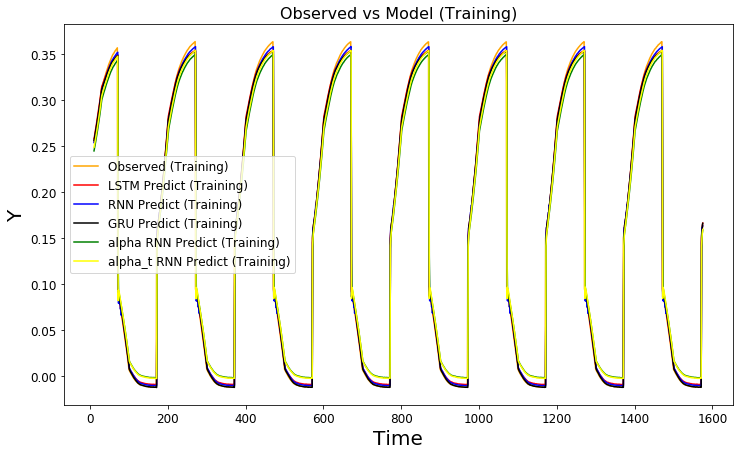

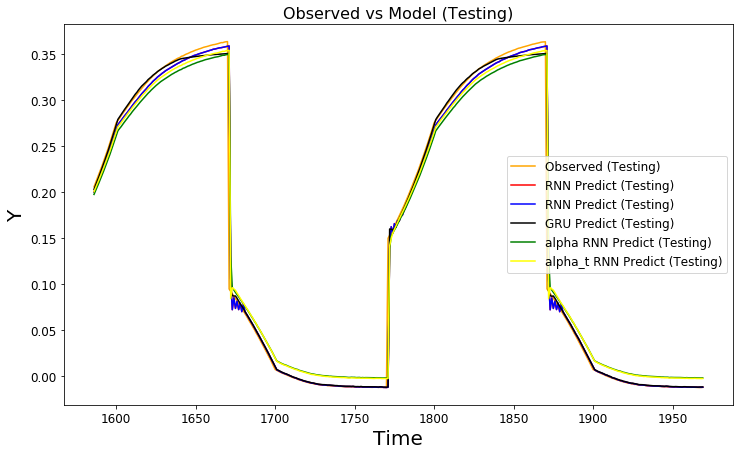

In [0]:
fig = plt.figure(figsize=(12,7))
train_line_real = plt.plot(df_train.index[n_steps:], df_train[use_feature][n_steps:], color="orange", label="Observed (Training)")
train_line_pred = plt.plot(df_train.index[n_steps:], lstm_pred_train[:, 0], color="red", label="LSTM Predict (Training)")
train_line_pred = plt.plot(df_train.index[n_steps:], rnn_pred_train[:, 0], color="blue", label="RNN Predict (Training)")
train_line_pred = plt.plot(df_train.index[n_steps:], gru_pred_train[:, 0], color="black", label="GRU Predict (Training)")
train_line_pred = plt.plot(df_train.index[n_steps:],y_predicted_train, color='green', label="alpha RNN Predict (Training)")
train_line_pred = plt.plot(df_train.index[n_steps:],y_predicted_train_t, color="yellow", label="alpha_t RNN Predict (Training)" )

plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model (Training)', fontsize=16)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Y', fontsize=20)

fig = plt.figure(figsize=(12,7))
test_line_real = plt.plot(df_test.index[n_steps:], df_test[use_feature][n_steps:], color="orange", label="Observed (Testing)")
test_line_pred = plt.plot(df_test.index[n_steps:], rnn_pred_test[:, 0], color="red", label="RNN Predict (Testing)")
test_line_pred = plt.plot(df_test.index[n_steps:], rnn_pred_test[:, 0], color="blue", label="RNN Predict (Testing)")
test_line_pred = plt.plot(df_test.index[n_steps:], gru_pred_test[:, 0], color="black", label="GRU Predict (Testing)")
test_line_pred = plt.plot(df_test.index[n_steps:], y_predicted_ar,color="green", label="alpha RNN Predict (Testing)")
test_line_pred = plt.plot(df_test.index[n_steps:], y_predicted_ar_t, color="yellow", label= "alpha_t RNN Predict (Testing)")
# train_line_pred = plt.plot(session.run(output, feed_dict={alpharnn.input_layer: x_test_reg})
plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model (Testing)', fontsize=16)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Y', fontsize=20)

plt.show()